# <center>An Analysis of the Determinants of Crime in North Carolina</center>
<center><font size="3">By Radhika Satapathy, Rahul Kulkarni,  Xander Hathaway, and Robert Calzaretta</font></center>
<center><font size="3">W203 Penner Section 2</font></center>
<center><font size="3">Final Report</font></center>

## <font color='blue'>1.0 Introduction</font>
RRXR Consulting has been tasked by the 1988 Gubernatorial re-election campaign of Governor James Martin to identify the key determinants of crime across the state of North Carolina and recommend crime-reduction policies for the Governor.  Specifically, the governor's campaign has asked our team, what is the relationship between crime rates and efficiency in law enforcement or the justice system?  To answer this question, our team focuses on understanding 'crime rate' and factors that could contribute to or reduce the crime based on  data such as U.S. Census demographic information, law enforcement statistics, and wage data. 

It is our primary assumption that creating policy suggestions focused on law enforcement and the justice system in North Carolina will allow for the most immediate impact on crime rate.  We also examine what other contributors to crimes committed per person might form a basis to help lower the crime rate across the state of North Carolina.  We proceed to identify such factors and incorporate them into a linear model applying ordinary least squares (OLS) estimates for the covariates of crime rates in North Carolinian counties.  We critique our models through analyses of residuals and through the econometric framework of classic linear models (CLM).  We consider potential sources of omitted variable bias in our analysis before finally making policy suggestions based on our findings.

## <font color='blue'>2.0 Initial Data Loading & Data Cleaning</font>
The data relied upon in this report is derived from the paper C. Cornwell and W. Trumball (1994), “Estimating the Economic Model of Crime with Panel Data,” Review of Economics and Statistics 76, 360-366.  It contains county-level data for the state of North Carolina in 1987.  The following sections outline the details of data loading and data cleaning conducted for our analysis.

In [93]:
###
#Load Packages
###
library(car)
library(lmtest)
library(ggcorrplot)
library(sandwich)
library(stargazer)

###
#Load Data
###
crimeData = read.csv("crime_v2.csv", header = TRUE)

The data set contains 25 fields and 90 observations after excluding records where all fields contain missing values and a duplicate entry for county 193.  The variables most immediately relevant to law enforcement and the policies of the justice system are 'prbarr', 'prbconv', 'prbpris', 'avgsen', and 'polpc' which measure the probabilities of arrest, conviction, and prison sentence, average sentencing time, and police per capita, respectively.  We consider these fields as potential candidates for key variables of interest against crime rates.

In [94]:
#eliminate last six rows of data that are empty
crimeData = na.omit(crimeData)
cat("Number of Observations")
length(crimeData$year)

#Identify any duplicate observations
cat("Duplicate County-Year Combinations")
crimeData[duplicated(crimeData$county),c('county','year')]

#Eliminate duplicate entry for county 193
crimeData <- unique(crimeData)
cat("Number of Observations After Dropping Duplicates")
length(crimeData$year)

cat('Number of Fields')
length(colnames(crimeData))

Number of Observations

[1] 91

Duplicate County-Year Combinations

,county,year
89,193,87


Number of Observations After Dropping Duplicates

[1] 90

Number of Fields

[1] 25

According to the U.S. Census Bureau's [Population of States and Counties of the United States: 1790 to 1990](https://www.census.gov/population/www/censusdata/pop1790-1990.html) there were 100 counties in North Carolina in 1987, indicating that our dataset is missing information for 10 counties.  This omission could potentially be a source of bias in our results.  Further investigation outside of this report is necessary to determine the extent of the bias.

Next, we examine the summary statistics of the data fields.

In [95]:
cat("Summary Statistics by Field")
summary(crimeData)

Summary Statistics by Field

     county           year        crmrte             prbarr       
 Min.   :  1.0   Min.   :87   Min.   :0.005533   Min.   :0.09277  
 1st Qu.: 51.5   1st Qu.:87   1st Qu.:0.020604   1st Qu.:0.20495  
 Median :103.0   Median :87   Median :0.030002   Median :0.27146  
 Mean   :100.6   Mean   :87   Mean   :0.033510   Mean   :0.29524  
 3rd Qu.:150.5   3rd Qu.:87   3rd Qu.:0.040249   3rd Qu.:0.34487  
 Max.   :197.0   Max.   :87   Max.   :0.098966   Max.   :1.09091  
                                                                  
        prbconv      prbpris           avgsen           polpc          
 0.068376102: 1   Min.   :0.1500   Min.   : 5.380   Min.   :0.0007459  
 0.140350997: 1   1st Qu.:0.3642   1st Qu.: 7.375   1st Qu.:0.0012378  
 0.154451996: 1   Median :0.4222   Median : 9.110   Median :0.0014897  
 0.203724995: 1   Mean   :0.4106   Mean   : 9.689   Mean   :0.0017080  
 0.207830995: 1   3rd Qu.:0.4576   3rd Qu.:11.465   3rd Qu.:0.0018856  
 0.220339   : 1   Max.   :0.6000

The cleaned data set contains 90 observations and 25 fields.

Summary statistics confirm that there are no missing values, however several variables stand out for additional cleaning/correction before they can be used for analysis:

__'prbconv':__ needs to be recast as a numeric value and divided by one hundred to be defined as a decimal consistent with the other probability fields. Similarly, the field 'pctmin80' must be divided by one hundred to be consistent with other fields defined as percentages.

__'prbarr':__ field is operationalized as the percent of offenses resulting in arrests. It therefore should take values between 0 and 1 as there should not be more arrests than offenses. A box plot shows that in one county this is not the case  - the field takes a value of 1.09. This stands out as erroneous and one that could have great leverage on any analysis relying upon the field. We therefore opt to replace it with the median value for the field across all rows of the data.

__'wser':__ Our summary statistics also reveal a potential outlier for the wser field which captures weekly average service sector wages. One county has a reported service sector wage greater than $2,177 -this is almost ten times greater than the mean wage and also substantially larger than the average wage in higher paying sectors(e.g. financial services or manufacturing). A box plot confirms that this is a significant outlier. It is possible that this observation stems from a single job or a set of jobs classified as service sector jobs in a county, but which is unrepresentive of a general service sector job in North Carolina. It is also possible that this is erroneous data. Either way, since it could greatly skew our analysis, we opt to replace this value with the median value for the field across all rows of the data from the same Western region of the state as indicated by the field 'west'.

__'density':__ The documentation of the data indicates that the population density field 'density' is measured as the "number of people" per square mile. If this were true, the maximum value of 8.82 implies that the densest county has less than 9 people per square mile. Given that there are urban counties in the data and that the 2018 estimate for population density for the state of North Carolina was 214 according to statistica.com, it appears that the values native to the data may actually be reflecting values corresponding to "hundreds of people" per square mile. Since this rule applies universally to all data points, we leave density as is, and choose to just interpret the metric in terms of hundreds of people per square mile.

__'pctmin80':__ There are two percentage fields in the data ('pctymle', 'pctmin80') whose values are represented differently - one is expressed as a decimal fraction and the other as a percentage. Expressing both these values in the same system would ensure consistency and ease in interpretation. Therefore, 'pctmin80' is divided by 100 to model 'pctymle'.

The section below details the corrections made to the above fields. The remaining fields in the data require no corrections at this time.

Summary of recasted prbconv:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0300  0.2525  0.4750  0.4750  0.6975  0.9200 

Summary of Arrest Probability After Revision:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.09277 0.20495 0.27120 0.28613 0.34331 0.68902 

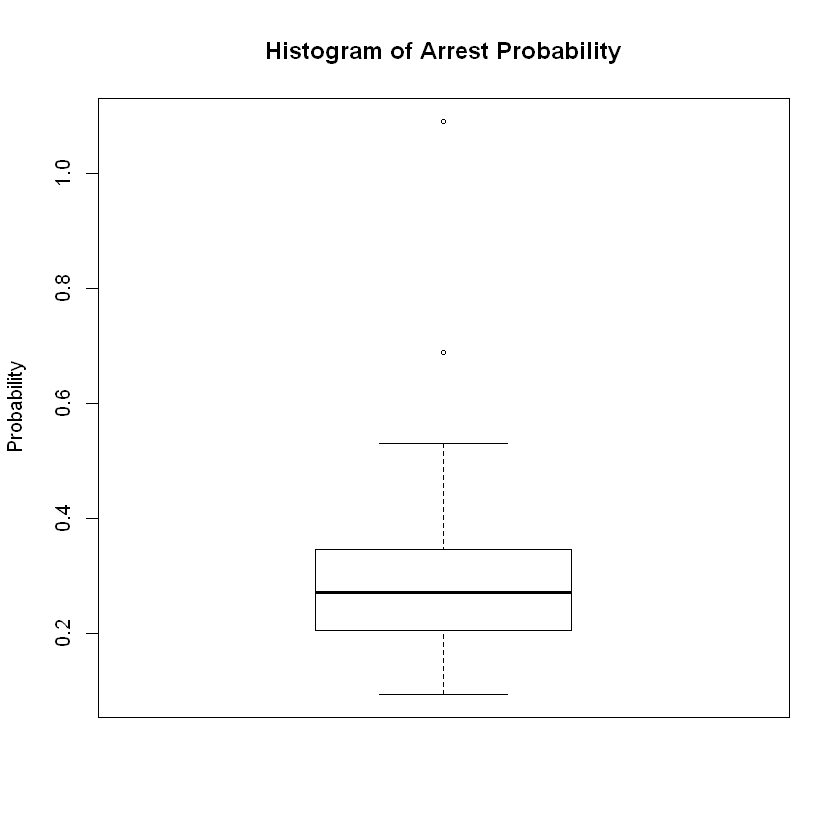

Region of Outlier

,west,central,urban
84,0,1,0


Summary of Service Sector Wages After Revision:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  133.0   229.3   252.2   253.9   275.9   391.3 

Summary of Density

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00002 0.54718 0.97925 1.43567 1.56926 8.82765 

Summary of Percent Minorities

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01284 0.10024 0.24852 0.25713 0.38183 0.64348 

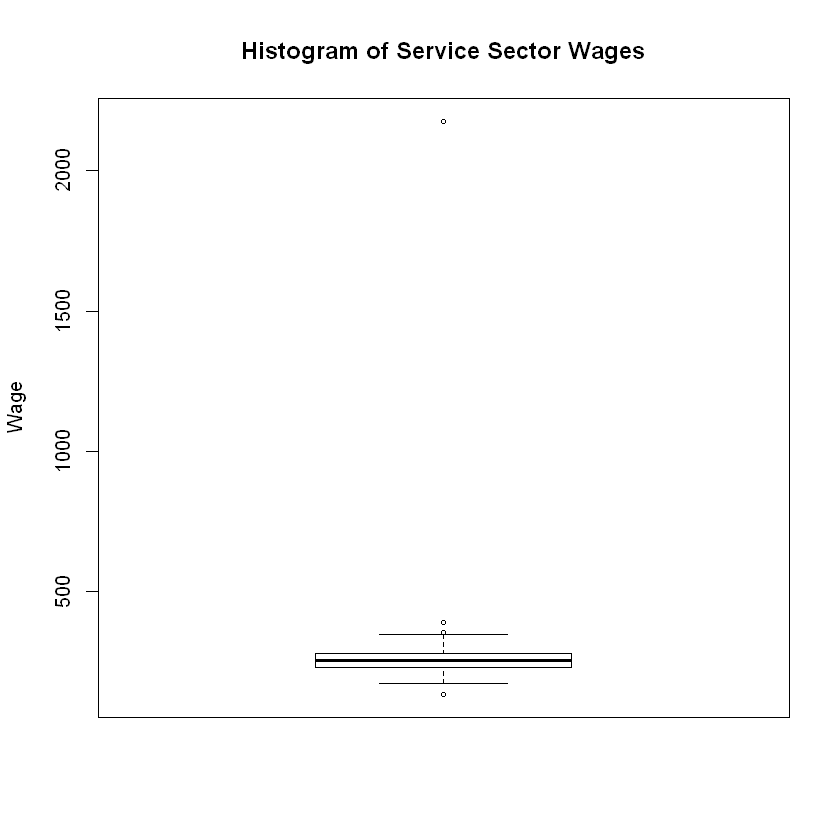

In [96]:
# Probability of conviction, 'prbconv' is stored as string; recasting as numeric
crimeData$prbconv = as.numeric(crimeData$prbconv)/100
cat('Summary of recasted prbconv:')
summary(crimeData$prbconv)

# Probability of arrest, 'prbarr' greater than 1; set to median value
boxplot(crimeData$prbarr, main="Histogram of Arrest Probability", ylab="Probability", cex=.5)
med = median(crimeData[, c('prbarr')])
crimeData[crimeData$prbarr>1, c('prbarr')] <- med
cat("Summary of Arrest Probability After Revision:")
summary(crimeData$prbarr)

# Large outlier for service industry wage, 'wser'.  
# Very unlikely to be a true value.  Capture median and replace.
boxplot(crimeData$wser, main="Histogram of Service Sector Wages", ylab="Wage", cex=.5)
cat("Region of Outlier")
crimeData[crimeData$wser>500, c('west','central','urban')]
med = median(crimeData[crimeData$west==1, c('wser')])
crimeData[crimeData$wser>500,c('wser')] <- med
cat("Summary of Service Sector Wages After Revision:")
summary(crimeData$wser)

# Summarize Density
cat("Summary of Density")
summary(crimeData$density)

# Standardize percentage of minorities field, 'pctmin80' to be decimal
crimeData$pctmin80 = crimeData$pctmin80/100
cat("Summary of Percent Minorities")
summary(crimeData$pctmin80)

## <font color='blue'>3.0 Exploratory Data Analysis</font>


As a first step, we construct plots to analyze the relationship between various variables provided in the data against crime rate.  These include comparing crime rate with fields related to crime enforcement, county demographics, and economic data such as tax rate and wages. Below we produce a correlation matrix of these potential covariates to better elucidate their relationship with crime rate and each other.

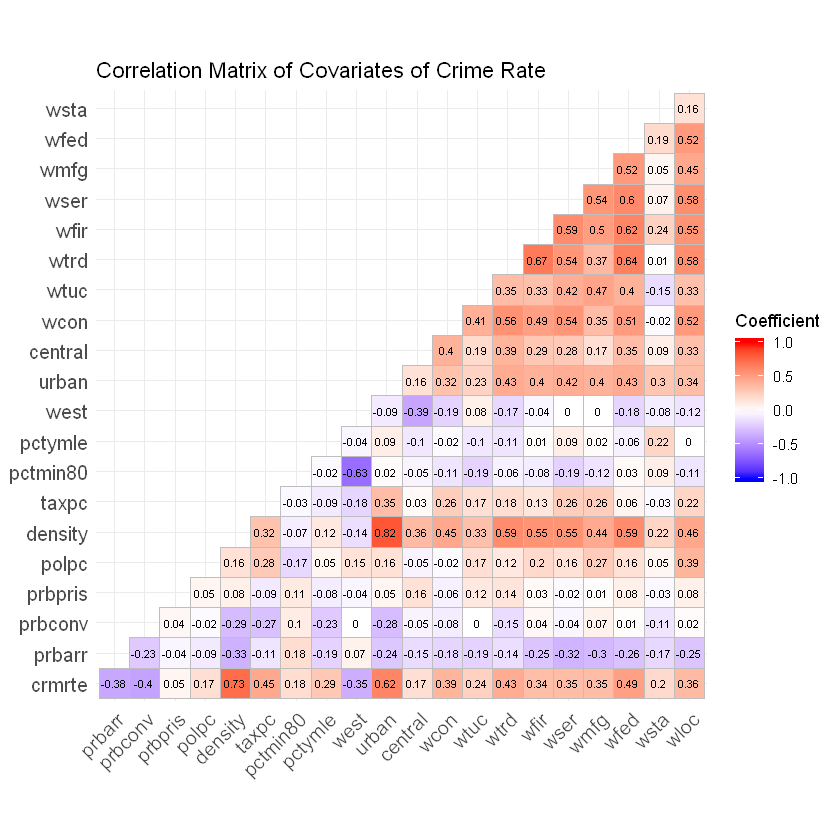

In [97]:
# Overall Correlogram
corr <- cor(crimeData[ ,c('crmrte','prbarr','prbconv', 'prbpris','polpc','density','taxpc','pctmin80','pctymle','west', 'urban', 'central','wcon','wtuc','wtrd','wfir','wser','wmfg','wfed','wsta','wloc')],use="complete.obs")
corr = round(corr,2)
ggcorrplot(corr, hc.order = F, type = "lower", lab=T, lab_size=2.25,
          legend.title="Coefficient",
          title="Correlation Matrix of Covariates of Crime Rate")

As the goal of our study is to evaluate policy decisions on law enforcement and the justice system, we take a more narrow look at some of the metrics reflcting these areas and their effect on crime rate: 

- 'prbarr': The probability that a reported crime results in arrest<br><br>
- 'prbconv': The probability that an arrest results in a sentence conviction<br><br>
- 'prbpris': The probability that a conviction results in prison time<br><br>
- 'avgsen': The average sentence for a prison conviction<br><br>
- 'polpc': The number of police per capita which reflects the density of police within a population<br><br>

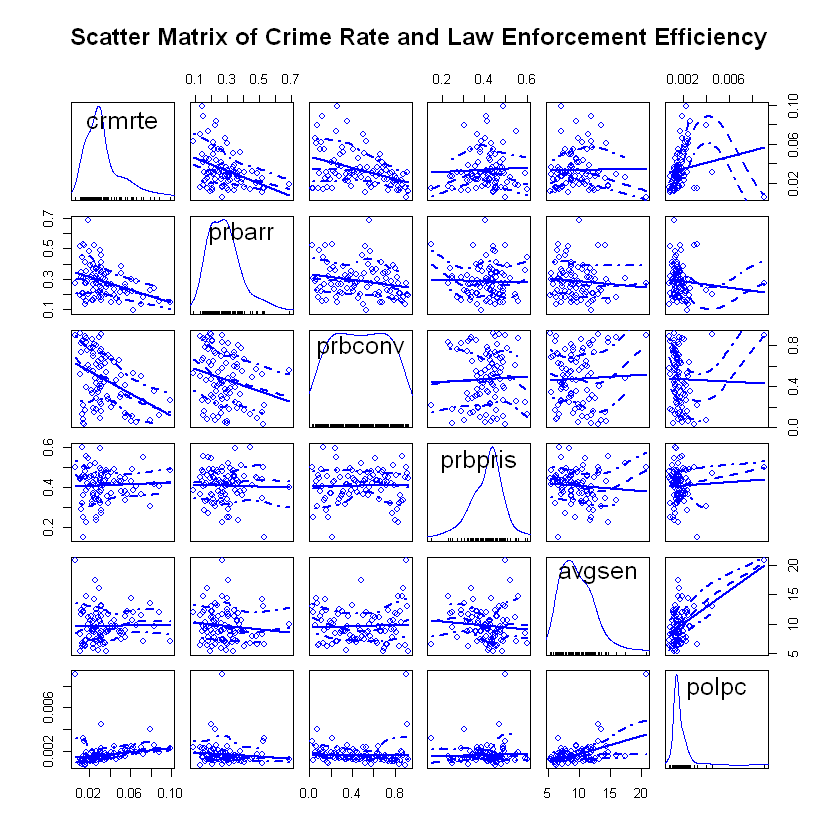

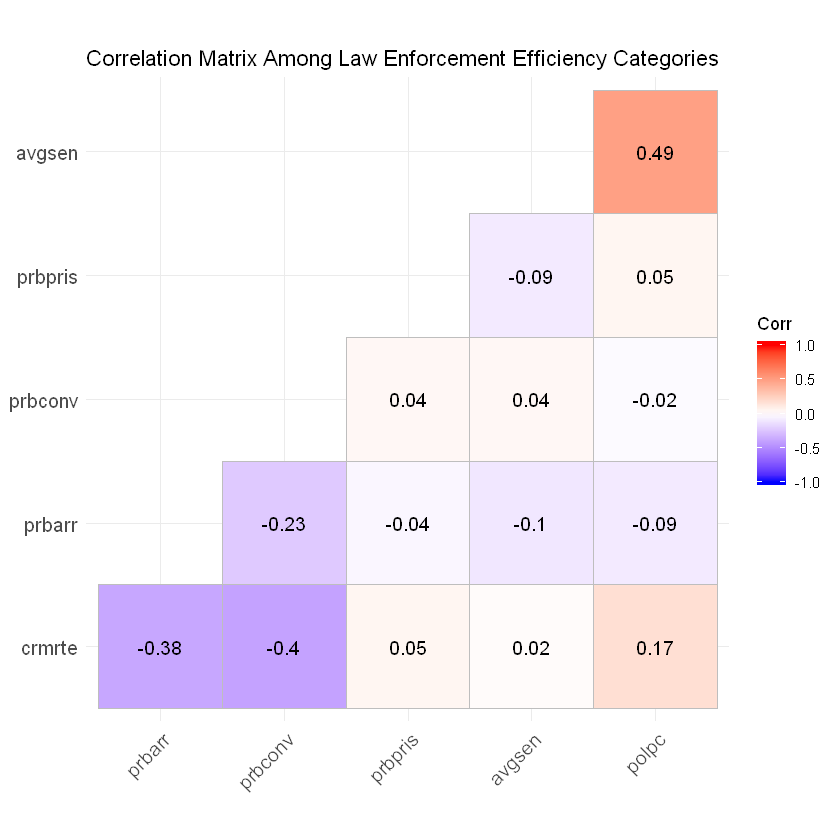

In [98]:
scatterplotMatrix(crimeData[,c('crmrte','prbarr','prbconv','prbpris','avgsen','polpc')], 
                  main='Scatter Matrix of Crime Rate and Law Enforcement Efficiency')

corr=round(cor(crimeData[c('crmrte','prbarr','prbconv','prbpris','avgsen','polpc')],use="complete.obs"),2)
ggcorrplot(corr, hc.order = F, type = "lower", lab = T, 
          title = "Correlation Matrix Among Law Enforcement Efficiency Categories")

The correlation matrix above shows prbarr and prbconv to be the items with the highest correlation with crime rate. The scatter matrix also conveys that these two metrics have the most obvious pattern in relation to crime rate. We can hypothesize that these two metrics measure the chances of a criminal being caught. Being caught with enough evidence to be convicted, manifests itself as more of a deterrent to crime than the resulting punishments of crime captured by 'prbpris' and 'avgsen'. This indicates the possibility that the accepted use of prison as a deterrent for crime may be an ineffective form of punishment. 

The 'polpc' metric represents the density of police in an area with respect to the population size. Although high police density may seem to indicate a higher detterence to crime (as law enforcement folks are the ones who can actually stop crime in the act), the data indicates the contrary, showing a slightly positive correlation with crime rate. In fact police density and crime rate may represent a chicken and the egg situation - local governments may supply areas with higher crime more police in an effort to combat the existing crime, or it may be the case where a high police presence is still not able to deter the high crime that is prevalent in the area.

Another rationale could be that areas seeming to reflect high crime numbers may just have more officers to report and catch crimes, resulting in higher reported crime rates, when compared to areas with the same number of crimes but with a lower police density numbers. Without any time series data it is difficult to establish the effect of police numbers on crime rates therefore we choose to exclude the police density variable from our causal model.

## <font color='blue'>4.0 Regression Models</font>

In this section, we implement three models of crime rate applying the research from our EDA.  

At the outset, we log transform our dependent variable, 'crmrte' variable for two reasons: 
 - First, a histogram of crmrte demonstrates a negative skew.  By taking the log-transformed version of crmrte,  we are able to better normalize the distribution of our dependent variable and thereby potentially reduce the risk of a non-normal distribution in our residuals as well as mitigate the risk of creating biased estimates.   
 <br>
 - Second, the transformed variable log(crmrte) allows for the interpretation in terms of a percentage increase or decrease in crime rate.  A 3% increase in the crime rate is more meaningful than a variation in crimes committed measured as 0.03 crimes per person. As there are no counties with zero or negative rates of crime, this log transformation will not cause any observations to be excluded due to undefined values or create any difficluties in interpretation. 


Number of observations with zero crime rate

[1] 0

Warning message in plot.window(xlim, ylim, "", ...):
""bins" is not a graphical parameter"Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
""bins" is not a graphical parameter"Warning message in axis(1, ...):
""bins" is not a graphical parameter"Warning message in axis(2, ...):
""bins" is not a graphical parameter"

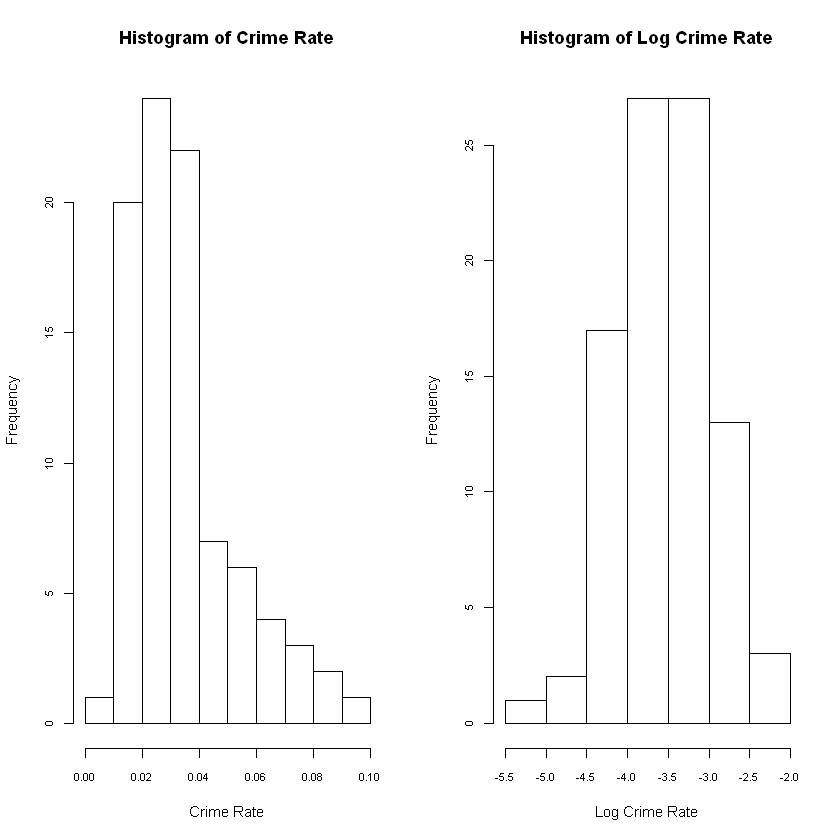

In [99]:
cat("Number of observations with zero crime rate")
length(crimeData[crimeData$crmrte<=0, c('crmrte')])

par(mfrow=c(1,2), cex=.75, cex.axis=.75)
hist(crimeData$crmrte, 
     main="Histogram of Crime Rate",
     xlab= "Crime Rate")
hist(log(crimeData$crmrte), bins=10,
     main="Histogram of Log Crime Rate",
     xlab= "Log Crime Rate")

### 4.1 Regression Model 1
#### 4.1.0 Model Design and Results
The baseline regression is specified as follows:<br><br>
$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{prbarr}  
    + \beta_{2} \mathrm{prbconv}  
    + \beta_{3} \mathrm{prbpris}     
    + u
\end{align}
$$ <br>
where

$ \beta_{0} $ is the constant effect on crime rate, 

$ \beta_{1} $ is the coefficient associated with a single percentage point increase in the probability of arrest, 

$ \beta_{2} $is the coefficient associated with a single percentage point increase in the probability of conviction, 

$ \beta_{3} $ is the coefficient associated with a single percentage point increase in the probability of sentencing, and

__u__ is the error term for the regression.

We omit the related variable 'avgsen'.  While it can be argued that this field can serve as a metric for the efficiency of law enforcement, with higher sentencing durations associated with law enforcement making better cases against criminals, the inclusion of this field count introduce several problems.  

First, it is not clear that a higher average sentencing alone would have an impact on crime rates as the nature of crimes will differ by county with certain crimes meriting higher sentencing.  Thus, a county might have a very high average sentence, but a low crime rate due to the nature of the few crimes committed in the county being more severe. 

Furthermore, as documented in [The North Carolina Sentencing and Policy Advisory Commission: A History of its Creation and its Development of Structured Sentencing](https://www.nccourts.gov/assets/documents/publications/commission_history_aug2009.pdf?O7ZRQnnfMS8XX67WIOodhh7g8.UPWR3_), sentencing standardization is still underway in North Carolina at this time.  Therefore, sentencing structures and the extent of judges discretion in sentencing still differ widely by county. A better metric related to sentencing might be the average ratio of sentence duration to maximum allowable sentence for given crimes.  However, such information is not readily available.  

Third, well documented racial bias in sentencing durations creates a potential distortion in interpretation with counties with higher populations of racial minority groups being characterized with higher sentencing durations, despite having comparable crime rates, than a county with fewer minority groups.  

Lastly, there could be countervailing forces determining the relationship between crime rate and average sentencing duration.  The prospect of a high average sentencing might deter criminals; however, average sentencing might be lowered in a given county just because crime rates are high and lower sentencing durations help speed up the legal process by reducing appeals or being an artifact of encouraging plea deals facilitating convictions.  

A more detailed data set would be necessary to more reliably examine the relationship between sentencing durations and crime rates.

In [100]:
# Model 1 - Base Model
model1 = lm(log(crmrte) ~ 
              prbarr 
            + prbconv 
            + prbpris
            , data=crimeData)
model1table <- stargazer(model1, type = "text", 
                 title = "Baseline Linear Model Predicting Crime Rate",
                 keep.stat = c("rsq", "adj.rsq", "n", "F"),
                 star.cutoffs = c(0.05, 0.01, 0.001))


Baseline Linear Model Predicting Crime Rate
                  Dependent variable:     
             -----------------------------
                      log(crmrte)         
------------------------------------------
prbarr                 -2.308***          
                        (0.455)           
                                          
prbconv                -1.025***          
                        (0.189)           
                                          
prbpris                  0.155            
                        (0.595)           
                                          
Constant               -2.458***          
                        (0.305)           
                                          
------------------------------------------
Observations              90              
R2                       0.344            
Adjusted R2              0.321            
F Statistic     15.000*** (df = 3; 86)    
Note:        *p<0.05; **p<0.01; ***p<0.001


The results from the base model indicate that the largest factor on crime rate is the probability of arrest, with a negative regression coefficient of 2.3, which implies that a percentage point increase in the probability of arrest is associated with a 2.3% reduction in crime rates.  This results is statistically significant to the 0.001 signifcance level using normal standard errors.  That is, we can strongly reject the null hypothesis that the probability of arrest has no effect on crime rate.  The coefficient for the probability of conviction is negative 1.0, implying that a percentage point increase in the probability of convictions is associated with a 1% reduction in crime.  This result is also statistically significant at the 0.001 level.  Lastly, the probability of a prison sentence is associated with a 0.2% _increase_ in crime rates.  The coefficient is not statistically significant; thus, we cannot reject the hypothesis that $B_3$ is zero or the probability of a prison sentence has no effect on crime rates.  The direction and relative size of these effects are in line with expectations.  Arrests, being the most immediate consequence of crime, have the largest negative impact on crime as their likelihood increases, while convictions also have a negative impact on crime, but the effect is smaller as might be expected as the consequence less immediately impacts criminals.  The effect of prison sentencing is nominally, although barely positive and statistically indistinguishable from zero which likely reflects the countervailing forces of a higher likelihood of receiving a prison sentence serving as a deterrent of crime, and a prison sentence increasing the likelihood of recidivism (_i.e._, the likelihood of a criminal reoffending).  This latter effect ([well documented](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4788463/) in the literature) appears to offset the former, suggesting that the psychological impact of prison and poor economic and social opportunities available to ex-inmates may be associated with repeated criminal behavior that outweighs the discouragement factor that a prison sentence might have for initial offenders.  

While the our $R^2$ of our baseline model is modest, suggesting that only 34% of the variation in crime rate is explained by our three covariates, the F-statistic for the model's overall signficance indicates that three covariates are jointly statistically signficant explanatory variables for crime rate at the 0.001 significance level.


#### 4.1.2 Evaluation Summary
An analysis of residuals and consideration for the assumptions of the CLM framework reveal that the results of our baseline model are unreliable.  Violations of the zero conditional mean and homoskedasticity of errors assumptions, along with the likely presence of endogeneity means that our estimates are likely biased and not consistent.  We will go into more details on these issues in the context of the CLM framework in Section 4.4.

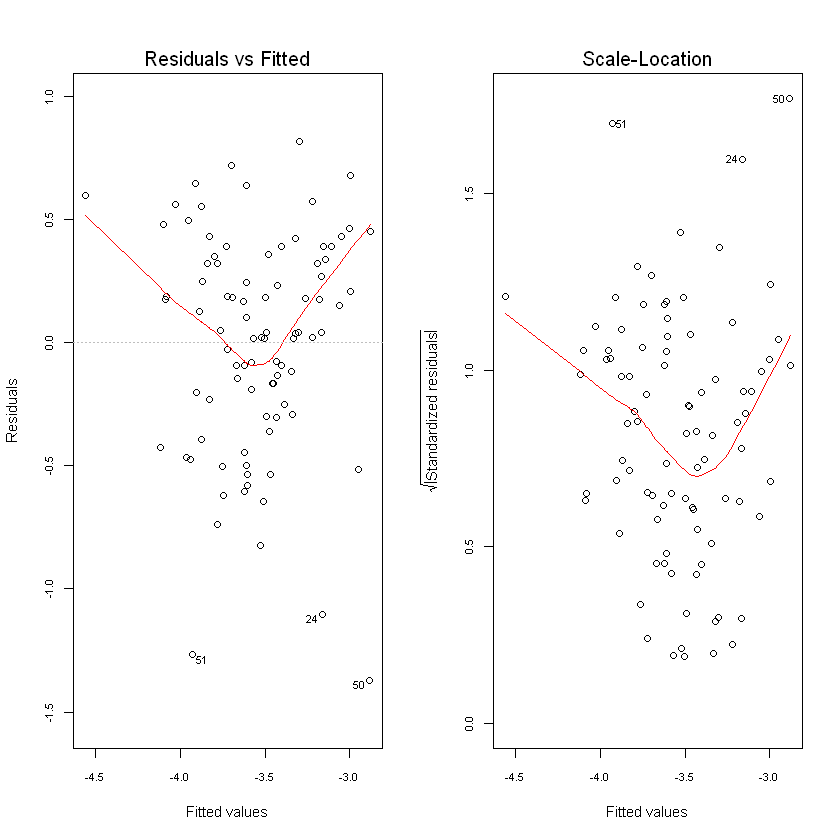

In [101]:
par(mfrow=c(1,2), cex=.75, cex.axis=.75)
plot(model1, which=1) #Residuals vs. Fitted
plot(model1, which=3) #Scale-Location

To account for the apparent heteroskedasticity in the error term, we revise our baseline model to apply robust standard errors.  The interpretation of the statistical significance of our coefficients remain the same after this adjustment; _i.e._, prbarr and prbconv remain significant at the 0.001 level.  In the next phase of our analysis, we will consider additional covariates of crime rate that can be added to our baseline model in an effort to enhance its reliability.

In [102]:
#coeftest(model1, vcov = vcovHC)
se.model1.robust = sqrt(diag(vcovHC(model1)))
model1table <- stargazer(model1, type = "text", 
                         title = "Baseline Model with Robust S.E.s",
                         keep.stat = c("rsq", "adj.rsq", "n", "F"),
                         se = list(se.model1.robust),
                         star.cutoffs = c(0.05, 0.01, 0.001))


Baseline Model with Robust S.E.s
                  Dependent variable:     
             -----------------------------
                      log(crmrte)         
------------------------------------------
prbarr                 -2.308***          
                        (0.554)           
                                          
prbconv                -1.025***          
                        (0.246)           
                                          
prbpris                  0.155            
                        (0.707)           
                                          
Constant               -2.458***          
                        (0.384)           
                                          
------------------------------------------
Observations              90              
R2                       0.344            
Adjusted R2              0.321            
F Statistic     15.000*** (df = 3; 86)    
Note:        *p<0.05; **p<0.01; ***p<0.001


### 4.2 Regression Model 2



We next construct a second model to improve over the base model with potential additional covariates and transformations.

The overall correlogram from section 3.0 reveals that crime rate is highly correlated with __density (0.73)__. Intuitively, greater the number of people, greater the number of crimes. This is one of the top reasons cited for significantly higher crime rates in urban areas. Crime rates generally follow a decreasing pattern across urban, suburban and rural regions for the very reason therefore any anomaly in this expected trend could call for a reform in resource allocation or improvement in efficiency of law enforcement agencies.

There also seems to be a slight correlation between crime rate and __percent minorities (0.18)__ and crime rate and __percentage of young males (0.29)__. Population in this demographic is most vulnerable to social problems such as alcohol and drug abuse, and in the backdrop of poverty, homelessness, parental neglect, unemployment, discrimination and feelings of racial bias, individuals from this demographic find most motivation for crime. Studies reveal that the greatest number of crimes are committed by those between the ages of 15-24. Therefore assessing the influence of percent minorities and young males on crime rate, might help form the basis for recommending correctional programs targeted  at this specific demographic.


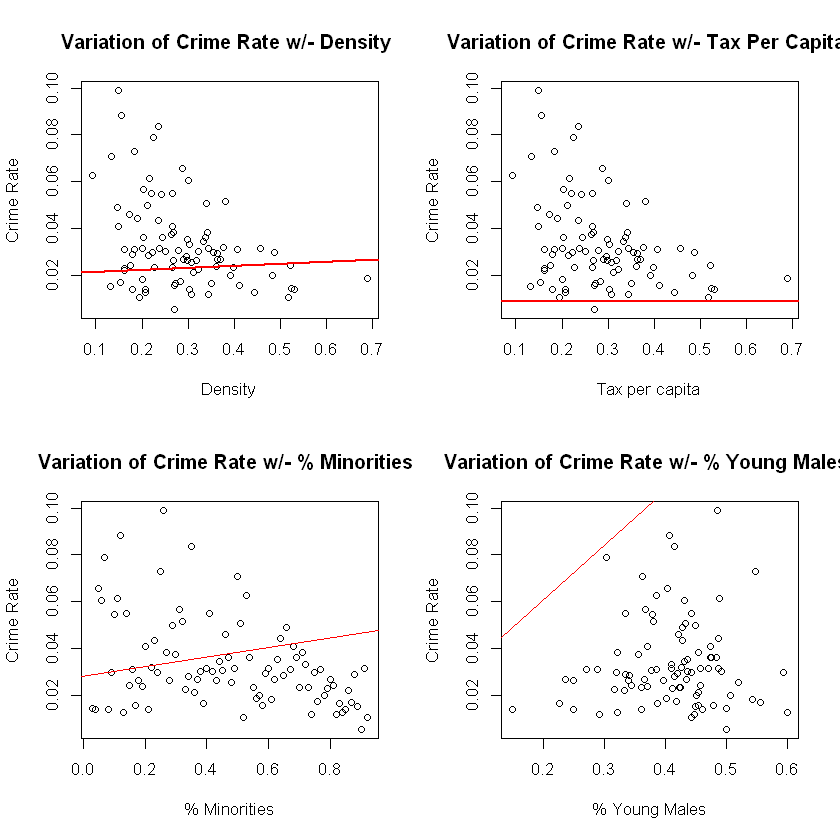

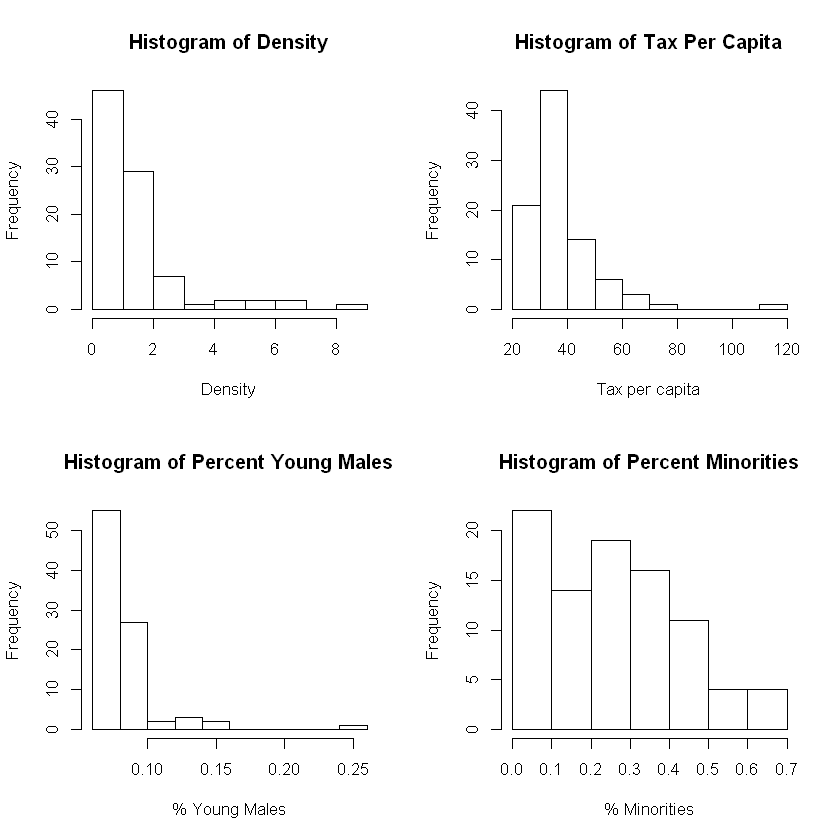

In [103]:
# Analysis of crime rate with socio-economic and demographic indicators

par(mfrow=c(2,2))

plot(crimeData$prbarr,crimeData$crmrte, main = 'Variation of Crime Rate w/- Density ', ylab = 'Crime Rate', xlab = 'Density' )
abline(lm(crimeData$crmrte ~ crimeData$density), col = "red" , lwd = 2 )

plot(crimeData$prbarr,crimeData$crmrte, main = 'Variation of Crime Rate w/- Tax Per Capita ', ylab = 'Crime Rate', xlab = 'Tax per capita' )
abline(lm(crimeData$crmrte ~ crimeData$taxpc), col = "red" , lwd = 2 )

plot(crimeData$prbconv, crimeData$crmrte, main = 'Variation of Crime Rate w/- % Minorities ', ylab = 'Crime Rate', xlab = '% Minorities')
abline(lm(crimeData$crmrte~crimeData$pctmin80), col="red") 

plot(crimeData$prbpris, crimeData$crmrte, main = 'Variation of Crime Rate w/- % Young Males ', ylab = 'Crime Rate', xlab = '% Young Males')
abline(lm(crimeData$crmrte~crimeData$pctymle), col="red")

hist(crimeData$density, main = 'Histogram of Density', xlab = 'Density')
hist(crimeData$taxpc, main = 'Histogram of Tax Per Capita', xlab = 'Tax per capita')
hist(crimeData$pctymle, main = 'Histogram of Percent Young Males', xlab = '% Young Males')
hist(crimeData$pctmin80, main = 'Histogram of Percent Minorities', xlab = '% Minorities')

Lastly, we also observe correlation between crime rate and __wage gap__.  [Outside research](https://www.economist.com/graphic-detail/2018/06/07/the-stark-relationship-between-income-inequality-and-crime) suggests that economic inequality could be cause for crime as the wider the gap, the greater the incentive to try and even the gap outside of legal means.  Our EDA suggests a non-linear relationship between the wage gap and crime rate and so we include wgap.sq to account for the apparent nonlinear relationship of the wage gap as it scales as demonstrated by the middle dotted-line in the scatter plot below.

Correlation between Crime Rate and Wage Gap

,crmrte,wgap
crmrte,1.0000000,0.1542737
wgap,0.1542737,1.0000000


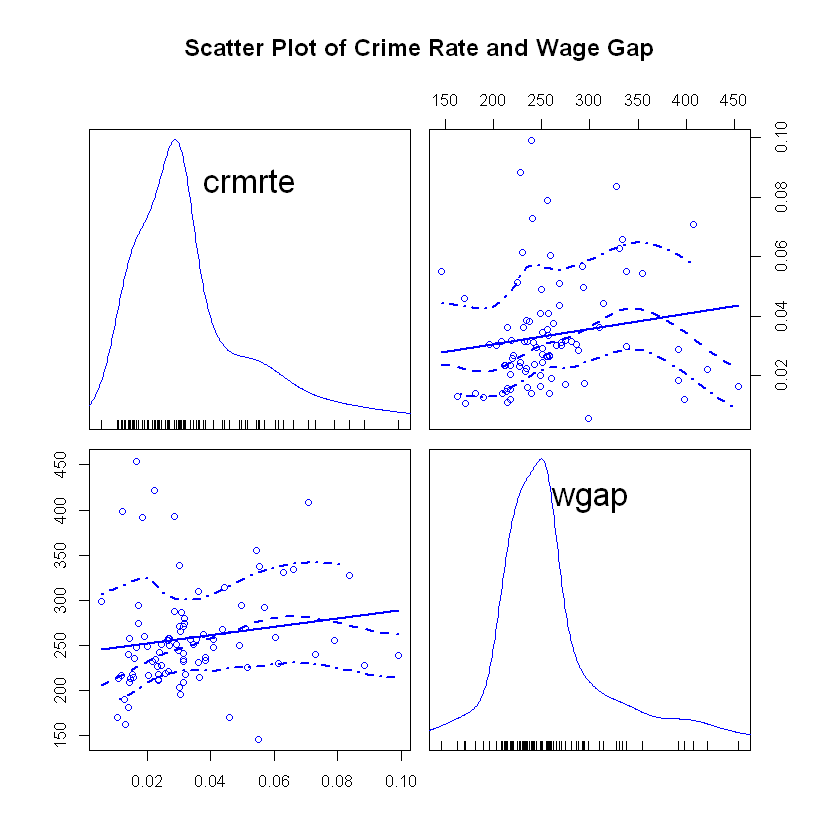

In [104]:
crimeData$wage.min <- apply(crimeData[15:23], 1, min)
crimeData$wage.max <- apply(crimeData[15:23], 1, max)
crimeData$wgap <- crimeData$wage.max-crimeData$wage.min

cat("Correlation between Crime Rate and Wage Gap")
cor(crimeData[c('crmrte','wgap')])

scatterplotMatrix(crimeData[,c('crmrte','wgap')], 
                  main='Scatter Plot of Crime Rate and Wage Gap')

crimeData$wgap.sq <- crimeData$wgap^2

#### 4.2.1 Model Design and Results

Based on the prior discussion on the correlation between density, percent minorities and percent young males on crime rate, we explore a model constructed by adding these variables to the base model. 

__Base Model__:
$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{prbarr}  
    + \beta_{2} \mathrm{prbconv}  
    + \beta_{3} \mathrm{prbpris}  
    + u
\end{align}
$$

__Model 2:__
$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{prbarr}  
    + \beta_{2} \mathrm{prbconv}  
    + \beta_{3} \mathrm{prbpris}  
    + \beta_{4} \mathrm{pctymle}  
    + \beta_{5} \mathrm{pctmin80}  
    + \beta_{6} \mathrm{wgap}      
    + \beta_{7} \mathrm{wgap.sq}      
    + \beta_{8} \mathrm{density}   
    + u
\end{align}
$$

In [105]:
model2 = lm(log(crmrte) ~ 
              prbarr 
            + prbconv 
            + prbpris
            + pctymle
            + wgap
            + wgap.sq
            + pctmin80
            + density

            , data=crimeData)

se.model2.robust = sqrt(diag(vcovHC(model2)))

stargazer(list(model2), type = "text", 
                 font.size='small',
                 column.sep.width = "1pt",
                 title = "Supplemental Linear Model Predicting Crime Rate",
                 se = list(se.model2.robust),
                 keep.stat = c("rsq", "adj.rsq", "n", "F"),
                 star.cutoffs = c(0.05, 0.01, 0.001))


Supplemental Linear Model Predicting Crime Rate
                  Dependent variable:     
             -----------------------------
                      log(crmrte)         
------------------------------------------
prbarr                 -1.547**           
                        (0.473)           
                                          
prbconv                -0.719**           
                        (0.237)           
                                          
prbpris                 -0.238            
                        (0.509)           
                                          
pctymle                  3.225            
                        (2.224)           
                                          
wgap                    0.011*            
                        (0.005)           
                                          
wgap.sq                -0.00002*          
                       (0.00001)          
                                          
pctmi

__4.2.3 Evaluation Summary__

The results above show that our baseline model results are fairly robust to the inclusion of additional controls; however, the inclusion of additional variables clearly impacts the results. Specifically, we see the effects of 'prbarr' and 'prbconv' diminish. This model suggests that a percentage point increase in the probabilities of arrest or conviction decrease crime by about 1.5% and 0.7% respectively. Moreover, with robust standard errors, the significance of these fields declines to the 0.01 level. We continue to see an effect of 'prbpris' that is statistically indistinguishable from zero, although the sign of the coefficient changes to be negative.

Next, we consider the new variables included in the regression. We find that the 'pctymle' effect is to increase crime rates by 3.2% as the percentage of young males in the county increases by a percentage point. While this value is not statistically significant at the 0.05 level, it is practically quite large, suggesting that it could merit further investigation by policymakers. 

We also find that 'pctmin80' has a positive 1.1% effect on crime rates per percentage point increase. This result is statistically significant at the 0.001 level suggesting strong evidence for racial bias in law enforcement or systemic racism driving crime rates in areas with larger minority populations. Additionally, density has a positive and statistically significant effect on crime rate with an increase in population density of 100 people per square mile associated with a large 15% increase in crime rates.

Lastly, we consider the more complicated effect of wage gap on crime rates. The regression result show that both the wgap and wgap.sq variables have a statistically significant effect at the 0.05 level. While the coefficient on wgap indicates the expected positive effect on crime rates, squared-term indicates that this effect diminishes as the wage gap increases. Per the equations below, while nominally an increase in the wage gap by one only dollar suggests a 1.1% increase in crime rates, factoring in the diminishing effect of negative 0.002% per dollar, we find that the wage gap only increase crime rate by 0.2% at the wage gap's mean value of $258.11. Restated, a one dollar increase from the mean value of wage gap only has a marginal effect on crime rate of 0.2%.

In [106]:
cat("Marginal Effect of Wage Gap:")
round(model2$coefficients[c('wgap')] *100,2)
cat("Mean Value of Wage Gap")
round(mean(crimeData$wgap),2)
cat("Marginal Effect of Wage Gap at Mean Value:")
round((model2$coefficients[c('wgap')] + 2*mean(crimeData$wgap)*model2$coefficients[c('wgap.sq')])*100,2)

Marginal Effect of Wage Gap:

wgap 
1.13

Mean Value of Wage Gap

[1] 258.11

Marginal Effect of Wage Gap at Mean Value:

wgap 
 0.2

There are a few other interesting items of note for our second model. We can see that the combination of our original three items from the first model still hold statistical significance.

In [107]:
#Test to verify key variables of interest are jointly significant
linearHypothesis(model2, c("prbarr = 0", "prbconv = 0", "prbpris = 0"), vcov = vcovHC)

Res.Df,Df,F,Pr(>F)
84,NA,NA,NA
81,3,4.310584,0.007145739


We also note that Model 2 strikes a good level of parsimony and fit as both the $R^2$ and adjusted $R^2$ almost double when compared to our first model. We will further evaluate the model's implications in the context of the CLM framework later.

### 4.3 Regression Model 3

Within model 3 we start to sacrifice some parsimony for additional explanatory power. 

Looking back at section 3.0, we can see that the __wage data__ across different sectors all has a relatively high correlation with crime rate. We suspected that higher wages would have provided better alternatives to crime and thus lower crime rate, but the data shows otherwise. While the wgap variable measures inequality, we add in wages across all sectors to measure economic viability in a more absolute sense.

The next significant factor correlated with crime rate appears to be __tax per capita (0.45)__. Police departments generally get funding through municipal and county taxes. Although other funding including state and federal funds exists in the form of grants, these are unsustainable. So in theory, counties with higher tax per capita may be able to better fund their law enforcement agencies which would directly result in better law enforcement which would in turn better be able to curtail  crime rates. We also see the tax per capita as a representation of economic strength. Areas with higher earning individuals will pump up the tax per capita and so this variable also helps us capture how well economic policies could effect crime rate. 

Also, a higher per capita tax also indicates the relative wealth of the people in the county. The relative wealth in the county results in greater investment in education and training programs for youth which translates to  gainful employment and therefore lesser motivation for crime. Although our scatter plot does not reveal a directional trend between crime rate and taxes per capita, it would be worthwhile to include it in our model to evaluate its effects.

__Base Model__:
$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{prbarr}  
    + \beta_{2} \mathrm{prbconv}  
    + \beta_{3} \mathrm{prbpris}  
    + u
\end{align}
$$

__Model 2:__
$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{prbarr}  
    + \beta_{2} \mathrm{prbconv}  
    + \beta_{3} \mathrm{prbpris}  
    + \beta_{4} \mathrm{pctymle}  
    + \beta_{5} \mathrm{pctmin80}  
    + \beta_{6} \mathrm{wgap}      
    + \beta_{7} \mathrm{wgap.sq}      
    + \beta_{8} \mathrm{density}   
    + u
\end{align}
$$

__Model 3:__
$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{prbarr}  
    + \beta_{2} \mathrm{prbconv}  
    + \beta_{3} \mathrm{prbpris}  
    + \beta_{4} \mathrm{pctymle}  
    + \beta_{5} \mathrm{wgap} 
    + \beta_{6} \mathrm{wgap.sq}  
    + \beta_{7} \mathrm{pctmin80}      
    + \beta_{8} \mathrm{density}   
    + \beta_{9} \mathrm{taxpc}      
    + \beta_{10} \mathrm{wcon}  
    + \beta_{11} \mathrm{wtuc}  
    + \beta_{12} \mathrm{wfir}  
    + \beta_{13} \mathrm{wser}  
    + \beta_{14} \mathrm{wmfg}  
    + \beta_{15} \mathrm{wfed}  
    + \beta_{16} \mathrm{wsta}  
    + \beta_{17} \mathrm{wloc}  
    + u
\end{align}
$$

#### 4.3.1 Model Design and Results

The advanced regression is specified as follows:

In [108]:
model3 = lm(log(crmrte) ~ 
              prbarr 
            + prbconv 
            + prbpris          
            + pctymle
            + wgap
            + wgap.sq           
            + pctmin80           
            + density           
            + taxpc
            + wcon
            + wtuc
            + wfir
            + wser
            + wmfg
            + wfed
            + wsta
            + wloc
            
            , data=crimeData)

se.model3.robust = sqrt(diag(vcovHC(model3)))
model3table <- stargazer(model3, type = "text", 
                 title = "Advanced Linear Model Predicting Crime Rate",
                 se = list(se.model3.robust),
                 keep.stat = c("rsq", "adj.rsq", "n", "F"),
                 star.cutoffs = c(0.05, 0.01, 0.001))
coeftest(model3, vcov = vcovHC)



Advanced Linear Model Predicting Crime Rate
                  Dependent variable:     
             -----------------------------
                      log(crmrte)         
------------------------------------------
prbarr                 -1.494***          
                        (0.446)           
                                          
prbconv                -0.666**           
                        (0.220)           
                                          
prbpris                 -0.131            
                        (0.486)           
                                          
pctymle                 4.761**           
                        (1.788)           
                                          
wgap                     0.004            
                        (0.010)           
                                          
wgap.sq                -0.00001           
                       (0.00002)          
                                          
pctmin80 


t test of coefficients:

               Estimate  Std. Error t value Pr(>|t|)   
(Intercept) -4.9834e+00  1.9106e+00 -2.6083 0.011057 * 
prbarr      -1.4939e+00  4.4587e-01 -3.3505 0.001287 **
prbconv     -6.6576e-01  2.1973e-01 -3.0300 0.003396 **
prbpris     -1.3112e-01  4.8576e-01 -0.2699 0.787990   
pctymle      4.7605e+00  1.7883e+00  2.6621 0.009572 **
wgap         4.1420e-03  1.0116e-02  0.4094 0.683437   
wgap.sq     -7.1128e-06  1.7590e-05 -0.4044 0.687146   
pctmin80     1.0242e+00  3.4265e-01  2.9892 0.003825 **
density      9.7294e-02  5.0177e-02  1.9390 0.056420 . 
taxpc        6.8650e-03  1.0573e-02  0.6493 0.518228   
wcon         1.5044e-03  1.4159e-03  1.0625 0.291556   
wtuc        -1.4375e-04  7.2294e-04 -0.1988 0.842943   
wfir        -1.1802e-03  1.3169e-03 -0.8962 0.373112   
wser        -1.5327e-03  1.8122e-03 -0.8458 0.400487   
wmfg         2.4700e-04  9.4552e-04  0.2612 0.794657   
wfed         3.1731e-03  1.7095e-03  1.8562 0.067519 . 
wsta        -1.0497e-0

#### 4.3.2 Evaluation Summary

The first thing we see out of our third model is a significantly higher $R^2$ value. This additional explantory value, however, comes at a cost of statistical significance. Below we can see that while our original three variables are still significant as a whole, the wage values in aggregate do not hold joing statistical significance. 

In [109]:
#Evaluate key coefficeints
paste('Law Enforcement Significance')
linearHypothesis(model3, c("prbarr = 0", "prbconv = 0", "prbpris = 0"), vcov = vcovHC)

#Are separate wage variables good indicators of different sectors of the economy?
paste('Wage Significance')
linearHypothesis(model3, c("wcon = 0", "wtuc = 0", "wfir = 0", "wser = 0", "wmfg = 0", "wfed = 0", "wsta = 0", "wloc = 0"), vcov = vcovHC)

[1] "Law Enforcement Significance"

Res.Df,Df,F,Pr(>F)
75,NA,NA,NA
72,3,5.044466,0.003147309


[1] "Wage Significance"

Res.Df,Df,F,Pr(>F)
80,NA,NA,NA
72,8,1.666501,0.1215431


Practically speaking, each of the wage variables increases or decreases crime rate by around a tenth of a percent, and thus holds little value outside of better fitting the regression line to the dataset. Between the unexpected associated of higher wages and higher crime rate and this lack of significance, the wage variables likely require additional research into their effects.

Our predictions for taxpc as both an economic indicator and as a helper for law enforcement also appears to be over estimated as the robust standard error for taxpc is greater than its small, positive coefficient. If anything, our model shows that a greater tax per capita results in slightly higher crime rate. This may be due to areas, like cities, of higher taxpc also being the same areas with higher density, minority levels, and young males.

### 4.4 Evaluating CLM Assumptions

We further evaluate the validity of our model through an analysis of the model's residuals below and a more in-depth consideration of the CLM assumptions typically applied in econometric framework adopted here. In this section we take a detailed look at the 6 CLM assumptions for __Model 2__ while mentioning a few highlights for the other two models. 


_4.4.1 Linearity in Parameters_

Our model is structured as a linear model of the ${\beta}$ parameters.  While some variables are higher order terms of the independent variables, the estimated coefficients share a linear relationship with the dependent variable. This holds for all three models.


_4.4.2 Random Sampling and "iid" Condition_

As discussed above, our sample contains 90 counties from North Carolina and the U.S. Census Bureau indicates that there are 100 total counties in North Carolina as of the 1980 Census.  The sampling regiment used to select these 90 counties is unknown; thus, we cannot be absolutely be certain that the sample was randomly selected, nor whether the included counties are independent and identically distributed ("iid"). While composing 90% of all counties in North Carolina, our data may disproportionally exclude rural counties, metropolitan counties, counties with the most extreme rates of crime, or _vice versa_.  We are unable to verify with certainty if such sampling biases persist.  Instead, we examine the counts of counties by region as denoted in the data with the total counts from  [NCPedia](https://www.ncpedia.org/geography/regions).  This reference indicates that there are 22 counties in the state's western region, 35 counties in the central region, and 43 counties in the coastal region.  The tabulations below reveal that our data has 22 counties in the western region, 34 counties in the central region (although one county is classified as both central and western), and 35 counties in the coastal region (defined as those counties where both the native central and west indicators are equal to zero).  This would suggest that the sample we rely upon under-represents coastal counties, possibly indicated a biased sample.  Given that 90% of the counties are represented in the sample, roughly 80% of the coastal counties are represented, and the largest population centers of the state are located in the western and central parts of the state, the impact of this bias is likely limited.  Nonetheless, further research should be conducted to ensure the sample is unbaised and iid. These conclusions apply to all three of our models.

In [110]:
crimeData$coast <- ifelse((crimeData$west!=1) & (crimeData$central!=1),1, 0)
cat("Tabulation of counties by region")
with(crimeData,
     table(coast)
     )

with(crimeData,
     table(west)
     )

with(crimeData,
     table(central)
     )
cat("Identify if counties with multiple classifications")
table(crimeData$central, crimeData$west)

Tabulation of counties by region

coast
 0  1 
55 35 

west
 0  1 
68 22 

central
 0  1 
56 34 

Identify if counties with multiple classifications

   
     0  1
  0 35 21
  1 33  1

_4.4.3 No Perfect Collinearity_<br>

None of the parameters included in this model are linear transformations of one another, therefore there is no issue of perfect collinearity among variables. Strong multicollinearity among parameters can increase the variance and thus reduce the precision of our estimates.  Given that the denominator of 'prbconv' is the numerator of 'prbarr', and the denominator of 'prbpris' is the numerator of 'prbconv', there is a possibility of the model potentially being susceptible to this issue.

We analyze variance inflation factors ("VIFs") as a diagnostic for testing strong multicollinearity among regressors.  VIFs measure the degree to which the variance of an estimated coefficient is inflated due to collinearity with another included parameter. Generally, a VIF greater than 10 indicates strong multicollinearity among regressors, a VIF of 4 indicates modest multicollinearity that merits attention, and a VIF of 1 indicates no correlation among a given regressor and other parameters.  

Focusing in on Model 2, we can see that all but two of the VIF scores fall under the 4 mark indicating none of these variables add significant multicollinearity. 

The high VIF score for wgap and wgap.sq is due to the inclusion of powers during the quadratic transformation which is an acceptable explanation. This suggests that multicollinearity is not a concern for Model2.

In [111]:
#Model 2: testing for multicollinearity
cat("VIFs for Model 1 Regressors")
round(vif(model1),3)

cat("VIFs for Model 2 Regressors")
round(vif(model2),3)

cat("VIFs for Model 3 Regressors")
round(vif(model3),3)

VIFs for Model 1 Regressors

prbarr prbconv prbpris 
  1.058   1.058   1.002

VIFs for Model 2 Regressors

prbarr  prbconv  prbpris  pctymle     wgap  wgap.sq pctmin80  density 
   1.478    1.417    1.033    1.220   52.229   51.691    1.121    1.394

VIFs for Model 3 Regressors

prbarr  prbconv  prbpris  pctymle     wgap  wgap.sq pctmin80  density 
   1.549    1.691    1.122    1.364  104.238   99.995    1.232    2.616 
   taxpc     wcon     wtuc     wfir     wser     wmfg     wfed     wsta 
   1.563    1.968    2.138    2.244    2.486    3.121    4.752    1.487 
    wloc 
   2.073

_4.4.4 Zero Conditional Mean and Exogeneity_

The next key assumption in the CLM framework is that the expected value of our errors conditional upon the included parameters is equal to zero; that is, $E(u|x_1,...,x_k)=0$. We can examine the extent to which this assumption holds using a __residuals vs. fitted value__ plot. 

The red line displayed on the plot for Model 2 below roughly tracks the horizontal line through zero however it trails off towards the right. This represents that the model has violated the zero conditional mean assumption, and this may be attributed to the many variables omitted from the model, details of which are discussed in section 5.0.

We can also see that in Model 3 the red line better follows the 0 mark, and Model 1, with far less parameters, exhibits a significant convex curve demonstrating that the zero conditional mean assumption is violated in first model

While the strong assumption of zero condition mean for errors may be slightly violated in our second model, the weaker assumption of exogeneity would still allow for our estimates to still be consistent.  That is, if the errors are uncorrelated with our parameters, we can claim that our estimates approach the population coefficients of our parameter as the sample size increases.  While it is not possible to test absolutely whether this assumption is violated, we can theorize the extent to which this assumption is valid in our model.

As Section 5.0 of this report will detail, it is very likely that the second model along with the other two models are susceptible to endogeneity as there are a plethora of omitted variables that are likely correlated with our parameters and unavailable in our data.  Such omitted factors include racial bias which can be correlated with probability of arrest.  For example, an area with a large population of African Americans might have a higher arrest rate all else equal due to police discrimination where people of color are more likely to face arrest rather than be given a warning.  That is, a county could have the exact same number of offenses, rate of convictions, and rate of prison sentencing, but an inflated arrest rate due to having a higher population of a group that is subject to biased policing.


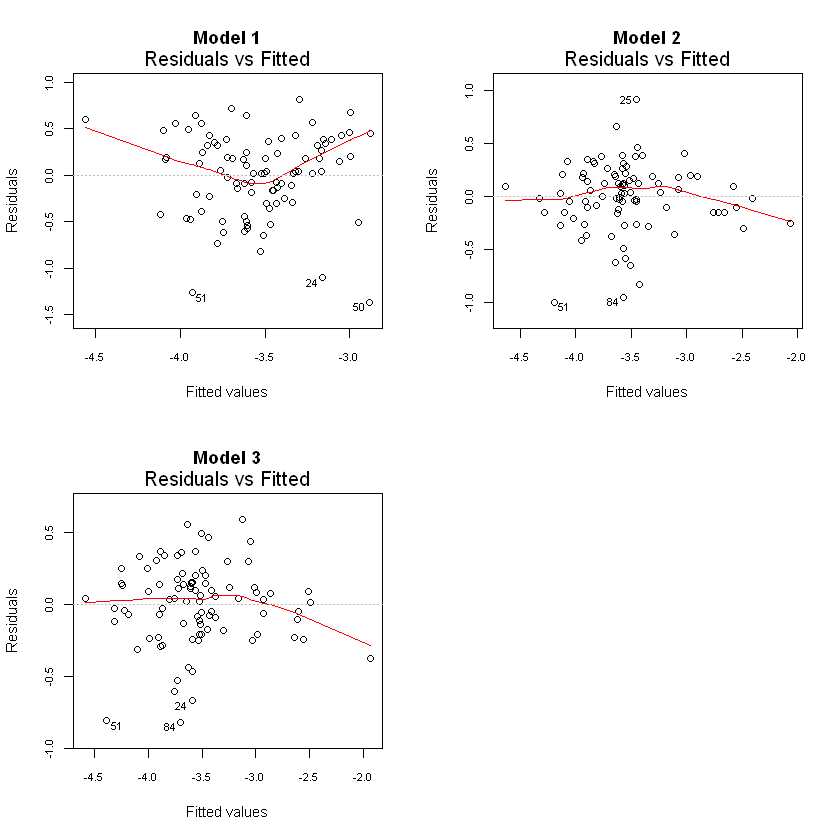

In [112]:
#Diagnostic plots for CLM4 & CLM5
par(mfrow=c(2,2), cex=.75, cex.axis=.75)
plot(model1, which=1, main='Model 1') #Residuals vs. Fitted
plot(model2, which=1, main='Model 2') #Residuals vs. Fitted
plot(model3, which=1, main='Model 3') #Residuals vs. Fitted

_4.4.5 Homoskedasticity of Errors_

The fifth key assumption in the CLM framework is the homoskedasticity, or constant variance, of errors.  The plot of __residuals vs. fitted values__ above reveals heteroskedasticity for Model 2 as is evidenced by the increase in variance of residuals along the red line.  

Heteroskedasticity is further confirmed by the __scale-location plot__ below where the red fit line takes a convex shape.  

Additionally, as demonstrated by the __residuals vs. leverage plot__ below, these findings do not appear to be driven by outliers in the data.  There are several outliers that have leverage, and none of them pass the Cooks threshold of 1. If the model continues to still exhibit heteroskedasticity, then we could choose to apply suitable transformations or add more variables to the model in order to reduce the variance in error.

The finding of heteroskedasticity has implications for the type of standard errors we should apply when guaging the precision of our OLS estimates.  The implication of heteroskedasticity is that our estimates cannot be considered BLUE (or the "best linear unbiased estimators").  We make our estimates robust to heteroskedasticity by applying White standard errors (or "robust standard errors").  It is generally best practice to apply robust standard errors when there is no overwhelming theoretical or empirical support for homoskedasticity.  Heteroskedasticity generally leads to overestimating hence robust standard errors are applied to more accurately interpret the estimated parameters. 

[1] "Model 2"

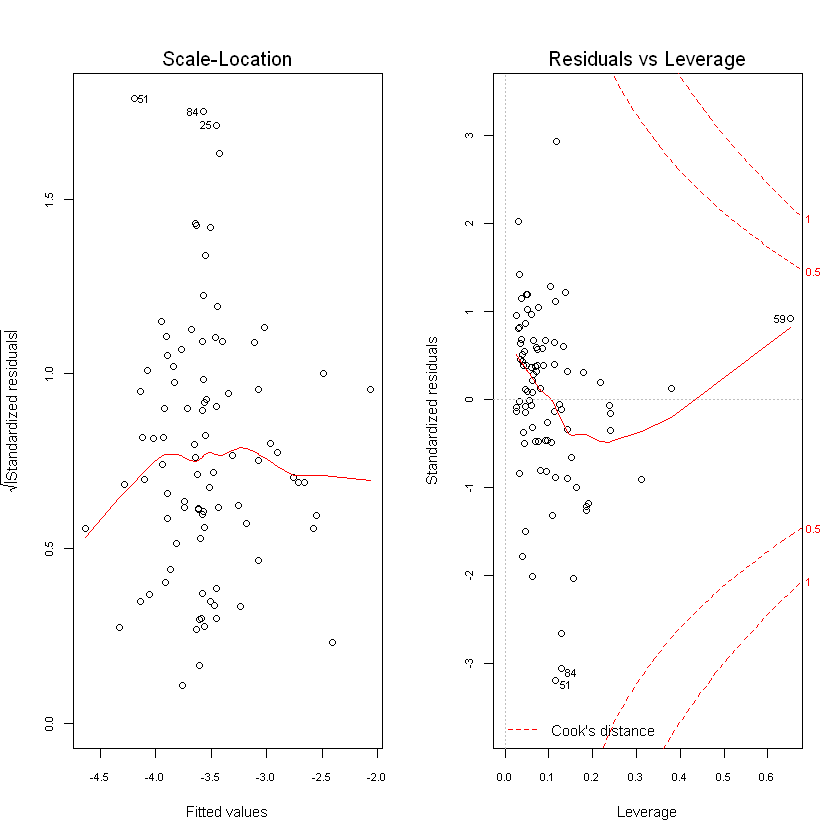

In [113]:
#Model 2 diagnostic plots for CLM5
paste('Model 2')
par(mfrow=c(1,2), cex=.75, cex.axis=.75)
plot(model2, which=3) #Scale-Location
plot(model2, which=5) #Residuals vs. Leverage


Models 1 and 2 shown below mirror Model 2 in that they also show heteroskedasticity.

[1] "Model 1"

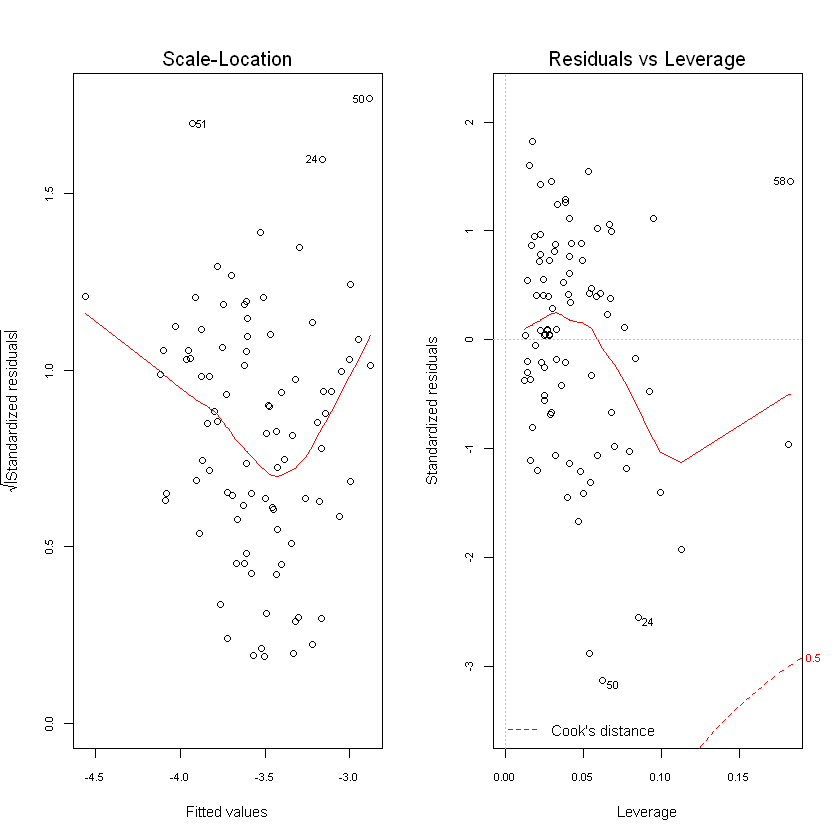

In [114]:
#Model 1
paste('Model 1')
par(mfrow=c(1,2), cex=.75, cex.axis=.75)
plot(model1, which=3) #Scale-Location
plot(model1, which=5) #Residuals vs. Leverage

Model 3 does contain 1 observation, point 25, that appears to exercise substanial influence as revealed by the residual's location beyond the dotted line indicating a Cook's distance of 0.5. This may mean that this point should be considered for exlusion for our model, but because it never crosses the threshold of 1 we choose to leave it in.

[1] "Model 3"

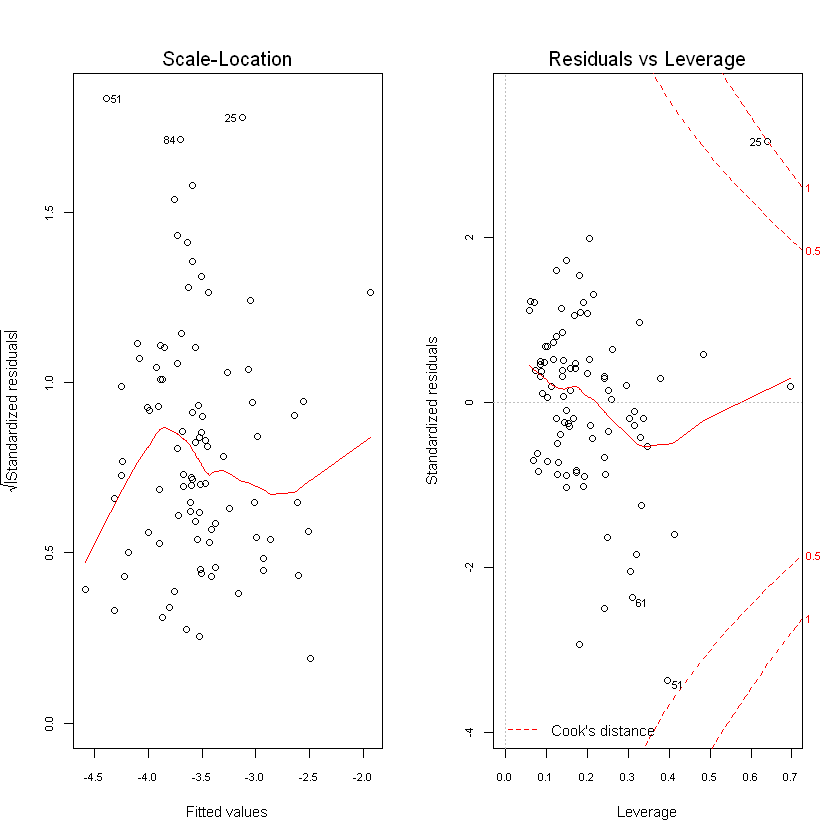

In [115]:
#Model 3
paste('Model 3')
par(mfrow=c(1,2), cex=.75, cex.axis=.75)
plot(model3, which=3) #Scale-Location
plot(model3, which=5) #Residuals vs. Leverage

_4.4.6 Normal Distribution of Errors_

The final assumption to consider in the CLM framework is the normal distribution of errors.  This assumption allows us to reliably conduct hypothesis tests against the value of our estimates and guage the statistical significance of our findings.  A histogram of the distribution of our second model's residuals indicate an approximately normal distribution.  While there is a slight skew with a longer lower-bound tail and the Normal Q-Q plot demonstrates deviation from normality at the tails, an observation count of 90 allows us to invoke the central limit theorem; that is, we can reasonably assume the distribution of these errors is approaching normal as the sample size increases.

We further test the normality of this distribution using the Shapiro-Wilk test.  The null hypothesis of this test is that the distribution of our population (in this case, the population model's errors) are normally distributed.  The resulting p-value when conducting this test our model's errors is [0.003] indicating that we reject the null hypothesis. Given the  tests tendency to reject even trivial deviations from normality in large samples and given our sufficiently large sample size, we choose to assume reliability from the results of the Q-Q plot and invoking the CLT.

[1] "Shapiro Test for Model 2 Residuals"


	Shapiro-Wilk normality test

data:  model2$residuals
W = 0.9543, p-value = 0.003114


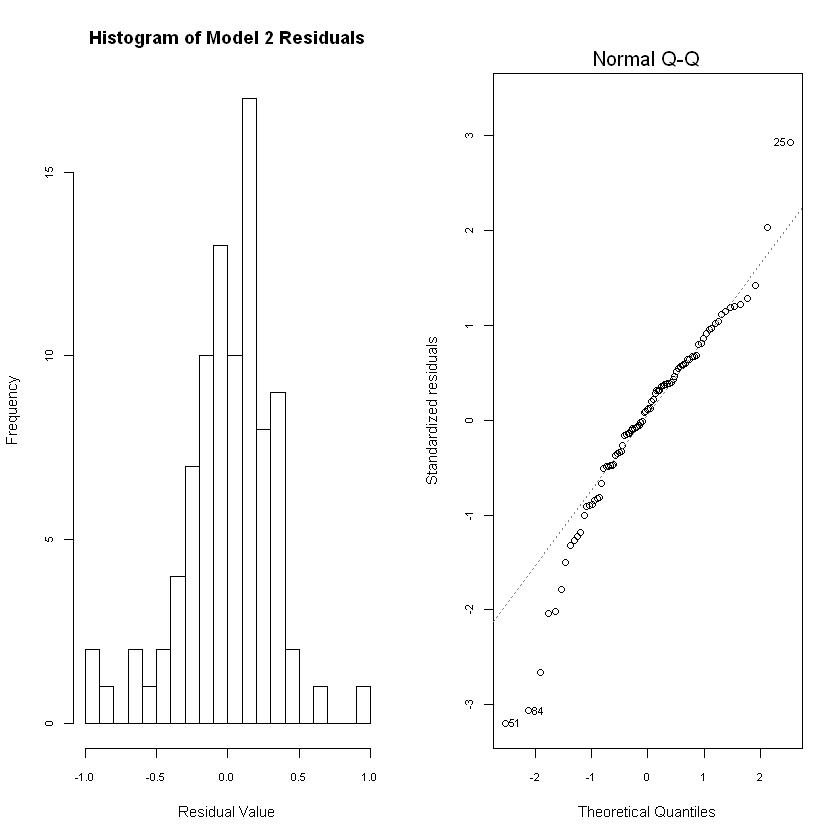

In [116]:
# Model 2
par(mfrow=c(1,2), cex=.75, cex.axis=.75)
hist(model2$residuals, breaks=15, 
     main='Histogram of Model 2 Residuals',
    xlab="Residual Value")
plot(model2, which=2)

paste('Shapiro Test for Model 2 Residuals')
shapiro.test(model2$residuals)

Models 1 shows less normality as shown by the deviations from the Normal Q-Q plot and the slightly larger p-value, but we still  reject the null hypothesis with the shapiro-wilk test.

[1] "Shapiro Test for Model 1 Residuals"


	Shapiro-Wilk normality test

data:  model1$residuals
W = 0.96494, p-value = 0.01575


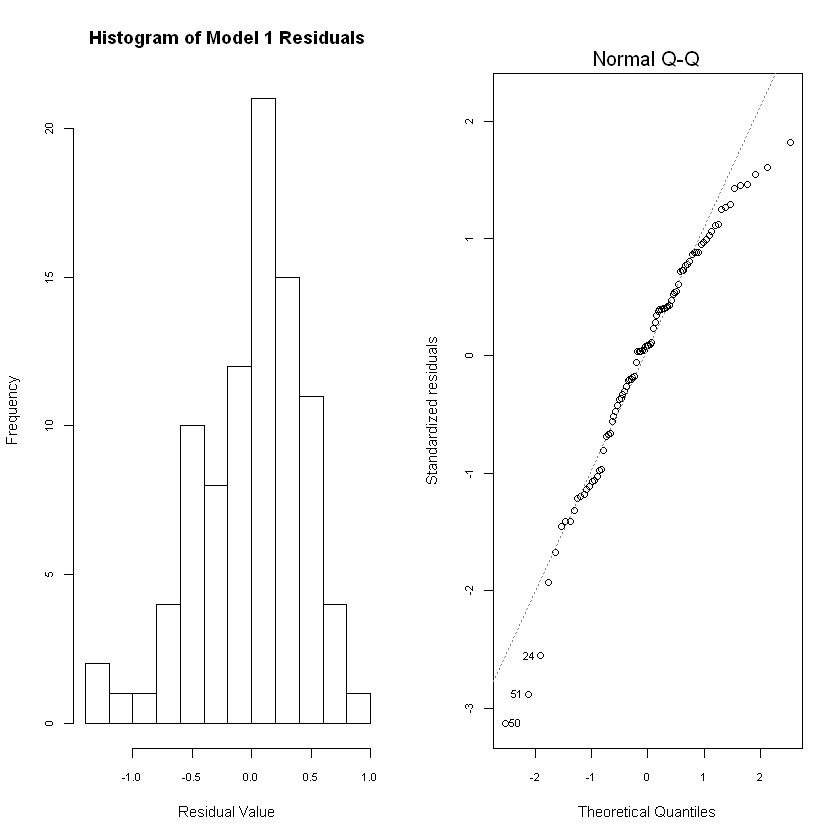

In [117]:
# Model 1
par(mfrow=c(1,2), cex=.75, cex.axis=.75)
hist(model1$residuals, breaks=15, 
     main='Histogram of Model 1 Residuals',
    xlab="Residual Value")
plot(model1, which=2)

paste('Shapiro Test for Model 1 Residuals')
shapiro.test(model1$residuals)

Only with Model 3 is the p-value large enough to fail to reject the null hypothesis of normality.

[1] "Shapiro Test for Model 3 Residuals"


	Shapiro-Wilk normality test

data:  model3$residuals
W = 0.97215, p-value = 0.05017


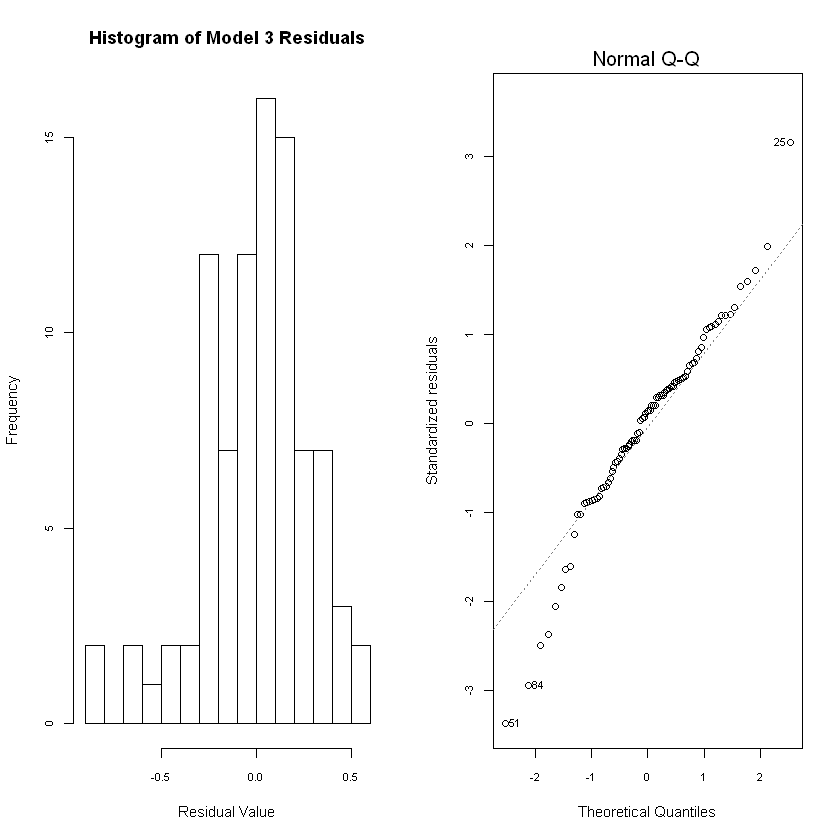

In [118]:
# Model 3
par(mfrow=c(1,2), cex=.75, cex.axis=.75)
hist(model3$residuals, breaks=15, 
     main='Histogram of Model 3 Residuals',
    xlab="Residual Value")
plot(model3, which=2)

paste('Shapiro Test for Model 3 Residuals')
shapiro.test(model3$residuals)

### 4.5 Comparison of Linear Models

#### 4.5.1 Regression Table

In the below regression table we evaluate included coefficents and their effects on crime rate amongst our 3 different models.

In [119]:
regressionTable <- stargazer(model1, model2, model3, type = "text", 
                 title = "Comparison of Linear Models Predicting Crime Rate",
                 se = list(se.model1.robust, se.model2.robust, se.model3.robust),
                 keep.stat = c("rsq", "adj.rsq", "n", "F"),
                 star.cutoffs = c(0.05, 0.01, 0.001))


Comparison of Linear Models Predicting Crime Rate
                                      Dependent variable:                         
             ---------------------------------------------------------------------
                                          log(crmrte)                             
                      (1)                    (2)                     (3)          
----------------------------------------------------------------------------------
prbarr             -2.308***               -1.547**               -1.494***       
                    (0.554)                (0.473)                 (0.446)        
                                                                                  
prbconv            -1.025***               -0.719**               -0.666**        
                    (0.246)                (0.237)                 (0.220)        
                                                                                  
prbpris              0.155          

We can measure the AIC for each model to measure the parsimony, goodness of fit, and benefit of adding in additional variables for each model. We can see a significant jump between Model 1 and Model 2 below, but Models 2 and 3 see a very small difference. This may be an indication that the overall explanatory power of model 3 is largely balanced out by the lack of explanatory power of each additional individual coefficient. 

In [120]:
#Evaluate AIC
cat("AIC for Model 1")
aic1 <- round(AIC(model1),3)
aic1

cat("AIC for Model 2")
aic2 <- round(AIC(model2),3)
aic2

cat("AIC for Model 3")
aic3 <- round(AIC(model3),3)
aic3

AIC for Model 1

[1] 118.505

AIC for Model 2

[1] 67.889

AIC for Model 3

[1] 62.374

These findings are further mirrored in a set of __Wald tests__ testing the statistical significance between the three models. We choose the Wald test as our models exhibit some heteroskedasticity and as the Wald test allows for including a robust covariance matrix . 

We see that there is a statistically significant difference in the __Power__ of Model 2 over Model 1 as shown by the incredibly small p-value. The second test, however, shows that there is no statistically significant difference between the Model 2 and Model 3. In our attempt to model crime rate, these findings suggest that while Model 2 has a lower __R^2__ value, its value may be greater due to itssimplicity, despite a similar explanatory power.

In [121]:
# Model 1 vs Model 2 Wald Test
waldtest(model1, model2, vcov = vcovHC)

# Model 2 vs Model 3 Wald Test
waldtest(model2, model3, vcov = vcovHC)

Res.Df,Df,F,Pr(>F)
86,NA,NA,NA
81,5,17.09207,1.653298e-11


Res.Df,Df,F,Pr(>F)
81,NA,NA,NA
72,9,1.73927,0.09562474


## <font color='blue'>5.0 Consideration of Omitted Variables</font>

Next, we consider variables that are not included within the data set that may bias our results. Within each omitted variable section we present the linear model for a single major variable affecting crime rate and how the omitted variable may bias a given included variable.

### 5.1 Metrics of Economic Inequality
Regression: ${log(crmrte)} = \beta_{0} + \beta_{1} \mathrm{taxpc}  + \epsilon$ 

__Omitted Variable: $\beta_{2} \mathrm{econIneq}$__ where econIneq tracks underlying inequality of income in a community. 

We attempt to capture inequality with wgap and wgap.sq, but these may be incomplete representations. A higher score for the econIneq would indicate more disparity between the wealthiest and poorest, while a lower score would indicate a last drastic distribution of wealth.

$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{taxpc}  
    + \beta_{2} \mathrm{econIneq}
    + \epsilon
\end{align}
$$

$$
\begin{align}
{econIneq} = \alpha_{0} 
    + \alpha_{1} \mathrm{taxpc}  
    + \epsilon
\end{align}
$$

If $\beta_{2} > 0$ and $\alpha_{1} > 0$ then $OMVB = \beta_{2}\alpha_{1} > 0$ and if $\beta_{1}$ > 0 then the OLS coefficient on taxpc will be scaled positively away from zero gaining statistical significance.

If the coefficient for income inequality ($\beta_{2}$) is positivily correlated with crime rate, say from poorer residents feeling the need to steal from wealthier residents for lack of financial support and structure, and if the coefficient for the tax revenue per capita ($\alpha_{1}$) is positively correlated with income inequality, say from the communities with the highest incomes to be taxed being in urban areas where poorer residences are also located, and if the coefficient for the tax revenue per capita($\beta_{1}$) is negatively correlated with crime rate, then the affects of taxpc on crime rate may not be biased strongly enough with the data that we do have. Including income inequality data may increase the statistical significance of taxpc on crmrte.

Including the enconomic inequality omitted variable would help to correct an overly confident score for taxpc by moving the taxpc coefficent towards zero losing statistical significance.



### 5.2 Measures of Racial or Other Demographic Bias
Regression: ${log(crmrte)} = \beta_{0} + \beta_{1} \mathrm{prbarr}  + \epsilon$ 

Omitted: $\beta_{2} \mathrm{racialBias}$ where racialBias tracks underlying racial bias in a community towards minorities. A higher value indicates more racism in the community.

$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{prbarr}  
    + \beta_{2} \mathrm{racialBias}
    + \epsilon
\end{align}
$$

$$
\begin{align}
{racialBias} = \alpha_{0} 
    + \alpha_{1} \mathrm{prbarr}  
    + \epsilon
\end{align}
$$

If $\beta_{2} > 0$ and $\alpha_{1} > 0$ then $OMVB = \beta_{2}\alpha_{1} > 0$ and if $\beta_{1}$ < 0 then the OLS coefficient on prbarr will be scaled towards zero losing statistical significance.

If the coefficient for racial bias ($\beta_{2}$) is positivily correlated with crime rate, say from systemic racism in the area, and if the coefficient for the probability of arrest ($\alpha_{1}$) is positively correlated with racial bias, say from officers being more likely to arrest minorities, and if the coefficient for the probability of arrest ($\beta_{1}$) is negatively correlated with crime rate, then the affects of prbarr on crime rate may be undervalues while excluding racial and demographic bias. Including racial bias data may increase the statistical significance of prbarr on crmrte moving it farther from zero in a negative direction.


### 5.3 Job Availability
Regression: ${log(crmrte)} = \beta_{0} + \beta_{1} \mathrm{density}  + \epsilon$ 

Omitted: $\beta_{2} \mathrm{jobAvail}$ where jobAvail tracks the availability of jobs in the area. A higher value indicates more more job opportunities for those within the community. More job availability may also coincide with a stronger economy, and those who are working have less time and incentive to commit crimes.
$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{density}  
    + \beta_{2} \mathrm{jobAvail}
    + \epsilon
\end{align}
$$

$$
\begin{align}
{jobAvail} = \alpha_{0} 
    + \alpha_{1} \mathrm{density}  
    + \epsilon
\end{align}
$$

If $\beta_{2} < 0$ and $\alpha_{1} > 0$ then $OMVB = \beta_{2}\alpha_{1} < 0$ and if $\beta_{1}$ > 0 then the OLS coefficient on density will be scaled positively away from zero gaining statistical significance.

If the coefficient for job availability ($\beta_{2}$) is negatively correlated with crime rate, perhaps because job opportunities indicate that residents are not forced to resort to crime, and if the coefficient for the density ($\alpha_{1}$) is positively correlated with job availability, say because more people creates a greater diversity of businesses, and if the coefficient for density ($\beta_{1}$) is positively correlated with crime rate, then the affects of density on crime rate may be biased too weakly with the data that we do have. Including job availability data may increase the statistical significance of density in a positive direction on crmrte.


### 5.4 Education Levels
Regression: ${log(crmrte)} = \beta_{0} + \beta_{1} \mathrm{pctymle}  + \epsilon$ 

Omitted: $\beta_{2} \mathrm{educLevel}$ where educLevel tracks the total level of education. This could be a combination of years in school, plus some weights for key years of education for graduation points from high school, associate's degree, bachelor's etc.
$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{pctymle}  
    + \beta_{2} \mathrm{educLevel}
    + \epsilon
\end{align}
$$

$$
\begin{align}
{educLevel} = \alpha_{0} 
    + \alpha_{1} \mathrm{pctymle}  
    + \epsilon
\end{align}
$$

If $\beta_{2} < 0$ and $\alpha_{1} < 0$ then $OMVB = \beta_{2}\alpha_{1} > 0$ and if $\beta_{1}$ > 0 then the OLS coefficient on prbarr will be scaled away from zero gaining statistical significance.

If the coefficient for education level ($\beta_{2}$) is negatively correlated with crime rate, perhaps because people with better education have more job opportunities and may come from more privilidged backgrounds, and if the coefficient for the percent young males ($\alpha_{1}$) is negatively correlated with education, perhaps because young males have had less time to gain education levels - particularly those of associate and bachelor degrees, and if the coefficient for the percent of young males ($\beta_{1}$) is positively correlated with crime rate, then the affects of pctymle on crime rate may be biased too strongly with the data that we do have. Including education levels data may decrease the statistical significance of pctymle on crmrte moving it negatively towards zero.

### 5.5 Willingness to Report

Regression: ${log(crmrte)} = \beta_{0} + \beta_{1} \mathrm{prbarr}  + \epsilon$ 

Omitted: $\beta_{2} \mathrm{wReport}$ where wReport tracks the willingness to report crimes. A rougher community in parts of Charlotte maybe be less likely to report pettier crimes like graffiti when compared to a small town in rural Carolina where there is less crime in the first place. Citizens may become desensitized to certain times of crime thus lowering the total number crimes reported.
$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{prbarr}  
    + \beta_{2} \mathrm{wReport}
    + \epsilon
\end{align}
$$

$$
\begin{align}
{wReport} = \alpha_{0} 
    + \alpha_{1} \mathrm{prbarr}  
    + \epsilon
\end{align}
$$

If $\beta_{2} < 0$ and $\alpha_{1} > 0$ then $OMVB = \beta_{2}\alpha_{1} < 0$ and if $\beta_{1}$ < 0 then the OLS coefficient on prbarr will be scaled more negatively and away from zero gaining statistical significance.

If the coefficient for willingness to report crimes ($\beta_{2}$) is negatively correlated with crime rate, which could be due to criminals being more fearful of being reported, and if the coefficient for the probability of arrest ($\alpha_{1}$) is postively correlated with willingness to report crimes, say because people are more likely to report crimes if they believe police will be able to act on the report, and if the coefficient for the probability of arrest($\beta_{1}$) is negatively correlated with crime rate, then the affects of prbarr on crime rate may be overestimated with the data that we do have. Including the willingness to report crimes may decrease the statistical significance of prbarr on crmrte and correct an overly confident model moving prbarr positvely towards zero.


### 5.6 Drug Use

Regression: ${log(crmrte)} = \beta_{0} + \beta_{1} \mathrm{prbarr}  + \epsilon$ 

Omitted: $\beta_{2} \mathrm{drugUse}$ where drugUse reflects the extent of substance abuse in a given area. Generally speaking, areas of high substance abuse are associated with more crime, and statistics of drug use provide a great indicator to potential crime. There is also a greater probability of substance abuse and associated crime in areas with higher percentage of vulnerable young males.
$$
\begin{align}
{log(crmrte)} = \beta_{0} 
    + \beta_{1} \mathrm{prbarr}  
    + \beta_{2} \mathrm{drugUse}
    + \epsilon
\end{align}
$$

$$
\begin{align}
{drugUse} = \alpha_{0} 
    + \alpha_{1} \mathrm{prbarr}  
    + \epsilon
\end{align}
$$

If $\beta_{2} > 0$ and $\alpha_{1} > 0$ then $OMVB = \beta_{2}\alpha_{1} > 0$ and if $\beta_{1}$ < 0 then the OLS coefficient on prbarr will be scaled towards zero losing statistical significance.

If the coefficient for drug use ($\beta_{2}$) is positively correlated with crime rate, given more drugs and addictions result in additional crimes to feed said additions, and if the coefficient for the probability of arrest ($\alpha_{1}$) is positively correlated with drugUse, caused by the war on drugs targeting drug users with more veracity, and if the coefficient for the probability of arrest ($\beta_{1}$) is negatively correlated with crime rate, then the affects of prbarr on crime rate may be too conservative when absorbing the effects of drug use. Including drug use may increase the statistical significance of prbarr more negatively.


#### 5.7 Additional Omitted Variable Consideration

Below we introduce a matrix covering a multitude of omitted variable biases on key coefficents.

In [122]:
omv <- read.csv("OMV.csv", sep = ',', header=T)

OVEconIneq <- omv[omv$OMV == 'EconIneq',]
print(paste("Omitted Variable: Economic Inequality Matrix"))
OVEconIneq

OVDemoBias <- omv[omv$OMV == 'DemoBias',]
print(paste("Omitted Variable: Demographic Bias Matrix"))
OVDemoBias

OVJobAvail <- omv[omv$OMV == 'JobAvail',]
print(paste("Omitted Variable: Job Availability Matrix"))
OVJobAvail

OVEduLevel <- omv[omv$OMV == 'EduLevel',]
print(paste("Omitted Variable: Education Level Matrix"))
OVEduLevel

OVSurvDensity <- omv[omv$OMV == 'Surv.Density',]
print(paste("Omitted Variable: Survey Density Matrix"))
OVSurvDensity

OVComUnity <- omv[omv$OMV == 'Com.Unity',]
print(paste("Omitted Variable: Community Unity Matrix"))
OVComUnity

OVWReport <- omv[omv$OMV == 'wReport',]
print(paste("Omitted Variable: Willingness to Report Matrix"))
OVWReport

OVPVoilent <- omv[omv$OMV == 'pViolent',]
print(paste("Omitted Variable: Violent Crime Matrix"))
OVPVoilent

OVDrugUse <- omv[omv$OMV == 'drugUse',]
print(paste("Omitted Variable: DrugUse Matrix"))
OVDrugUse


[1] "Omitted Variable: Economic Inequality Matrix"


IndpVar,OMV,IndpVar.Coeff.Sign,OMV.sign,OMV.Cor.with.IndpVar,Expected.Direction.Size.of.Bias,Proxy.Variable
prbarr,EconIneq,Negative,Positive,Positive,Underestimate/Moderate,wgap
prbconv,EconIneq,Negative,Positive,Positive,Underestimate/Moderate,
prbpris,EconIneq,,Positive,,,
taxpc,EconIneq,Positive,Positive,,,
pctymle,EconIneq,Positive,Positive,Positive,Overestimate/Small,
wgap(wgap^2),EconIneq,Positive,Positive,Positive,Overestimate/Small,
pctmin80,EconIneq,Positive,Positive,Negative,Underestimate/Moderate,
west,EconIneq,Negative,Positive,Positive,Underestimate/Small,
Density,EconIneq,Positive,Positive,Positive,Overestimate/Small,


[1] "Omitted Variable: Demographic Bias Matrix"


,IndpVar,OMV,IndpVar.Coeff.Sign,OMV.sign,OMV.Cor.with.IndpVar,Expected.Direction.Size.of.Bias,Proxy.Variable
10,prbarr,DemoBias,Negative,Positive,Positive,Underestimate/Large,west
11,prbconv,DemoBias,Negative,Positive,Positive,Underestimate/Large,
12,prbpris,DemoBias,,Positive,,,
13,taxpc,DemoBias,Positive,Positive,,,
14,pctymle,DemoBias,Positive,Positive,Positive,Overestimate/Large,
15,wgap(wgap^2),DemoBias,Positive,Positive,Positive,Overestimate/Moderate,
16,pctmin80,DemoBias,Positive,Positive,Negative,Overestimate/Moderate,
17,west,DemoBias,Negative,Positive,Positive,Underestimate/Moderate,
18,Density,DemoBias,Positive,Positive,,,


[1] "Omitted Variable: Job Availability Matrix"


,IndpVar,OMV,IndpVar.Coeff.Sign,OMV.sign,OMV.Cor.with.IndpVar,Expected.Direction.Size.of.Bias,Proxy.Variable
19,prbarr,JobAvail,Negative,Negative,,,wage variables (higher wages could be an indication of competition for labor)
20,prbconv,JobAvail,Negative,Negative,,,
21,prbpris,JobAvail,,Negative,,,
22,taxpc,JobAvail,Positive,Negative,Positive,Underestimate/Moderate,
23,pctymle,JobAvail,Positive,Negative,,,
24,wgap(wgap^2),JobAvail,Positive,Negative,Negative,Overestimate/Small,
25,pctmin80,JobAvail,Positive,Negative,Negative,Overestimate/Small,
26,west,JobAvail,Negative,Negative,Negative,Underestimate/Large,
27,Density,JobAvail,Positive,Negative,Positive,Underestimate/Moderate,


[1] "Omitted Variable: Education Level Matrix"


,IndpVar,OMV,IndpVar.Coeff.Sign,OMV.sign,OMV.Cor.with.IndpVar,Expected.Direction.Size.of.Bias,Proxy.Variable
28,prbarr,EduLevel,Negative,Negative,,,
29,prbconv,EduLevel,Negative,Negative,Negative,Underestimate/Small,
30,prbpris,EduLevel,,,,,
31,taxpc,EduLevel,Positive,Negative,Positive,Underestimate/Small,
32,pctymle,EduLevel,Positive,Negative,Negative,Overestimate/Small,
33,wgap(wgap^2),EduLevel,Positive,Negative,Negative,Overestimate/Small,
34,pctmin80,EduLevel,Positive,Negative,Negative,Overestimate/Small,
35,west,EduLevel,Negative,Negative,Negative,Underestimate/Small,
36,Density,EduLevel,Positive,Negative,Positive,Underestimate/Moderate,


[1] "Omitted Variable: Survey Density Matrix"


,IndpVar,OMV,IndpVar.Coeff.Sign,OMV.sign,OMV.Cor.with.IndpVar,Expected.Direction.Size.of.Bias,Proxy.Variable
37,prbarr,Surv.Density,Negative,Negative,Positive,Overestimate/Small,
38,prbconv,Surv.Density,Negative,Negative,Positive,Overestimate/Small,
39,prbpris,Surv.Density,,,,,
40,taxpc,Surv.Density,Positive,Negative,Positive,Underestimate/Moderate,
41,pctymle,Surv.Density,Positive,Negative,,,
42,wgap(wgap^2),Surv.Density,Positive,Negative,,,
43,pctmin80,Surv.Density,Positive,Negative,,,
44,west,Surv.Density,Negative,Negative,,,
45,Density,Surv.Density,Positive,Negative,Positive,Underestimate/Small,


[1] "Omitted Variable: Community Unity Matrix"


,IndpVar,OMV,IndpVar.Coeff.Sign,OMV.sign,OMV.Cor.with.IndpVar,Expected.Direction.Size.of.Bias,Proxy.Variable
46,prbarr,Com.Unity,Negative,Negative,,,
47,prbconv,Com.Unity,Negative,Negative,,,
48,prbpris,Com.Unity,,Negative,,,
49,taxpc,Com.Unity,Positive,Negative,,,
50,pctymle,Com.Unity,Positive,Negative,,,
51,wgap(wgap^2),Com.Unity,Positive,Negative,Negative,Overestimate/Moderate,
52,pctmin80,Com.Unity,Positive,Negative,Positive,Underestimate/Small,
53,west,Com.Unity,Negative,Negative,Negative,Underestimate/Small,
54,Density,Com.Unity,Positive,Negative,,,


[1] "Omitted Variable: Willingness to Report Matrix"


,IndpVar,OMV,IndpVar.Coeff.Sign,OMV.sign,OMV.Cor.with.IndpVar,Expected.Direction.Size.of.Bias,Proxy.Variable
55,prbarr,wReport,Negative,Negative,Positive,Overestimate/Moderate,mix
56,prbconv,wReport,Negative,Negative,Positive,Overestimate/Moderate,
57,prbpris,wReport,,Negative,,,
58,taxpc,wReport,Positive,Negative,,,
59,pctymle,wReport,Positive,Negative,,,
60,wgap(wgap^2),wReport,Positive,Negative,,,
61,pctmin80,wReport,Positive,Negative,,,
62,west,wReport,Negative,Negative,,,
63,Density,wReport,Positive,Negative,,,


[1] "Omitted Variable: Violent Crime Matrix"


,IndpVar,OMV,IndpVar.Coeff.Sign,OMV.sign,OMV.Cor.with.IndpVar,Expected.Direction.Size.of.Bias,Proxy.Variable
64,prbarr,pViolent,Negative,Positive,Negative,Overestimate/Small,mix
65,prbconv,pViolent,Negative,Positive,Positive,Underestimate/Small,
66,prbpris,pViolent,,Positive,,,
67,taxpc,pViolent,Positive,Positive,Negative,Underestimate/Small,
68,pctymle,pViolent,Positive,Positive,Positive,Overestimate/Small,
69,wgap(wgap^2),pViolent,Positive,Positive,,,
70,pctmin80,pViolent,Positive,Positive,,,
71,west,pViolent,Negative,Positive,,,
72,Density,pViolent,Positive,Positive,,,


[1] "Omitted Variable: DrugUse Matrix"


,IndpVar,OMV,IndpVar.Coeff.Sign,OMV.sign,OMV.Cor.with.IndpVar,Expected.Direction.Size.of.Bias,Proxy.Variable
73,prbarr,drugUse,Negative,Positive,Positive,Underestimate/Moderate,mix
74,prbconv,drugUse,Negative,Positive,Positive,Underestimate/Moderate,
75,prbpris,drugUse,,Positive,,,
76,taxpc,drugUse,Positive,Positive,Negative,Underestimate/Moderate,
77,pctymle,drugUse,Positive,Positive,Positive,Overestimate/Small,
78,wgap(wgap^2),drugUse,Positive,Positive,,,
79,pctmin80,drugUse,Positive,Positive,,,
80,west,drugUse,Negative,Positive,,,
81,Density,drugUse,Positive,Positive,,,


## <font color='blue'>6.0 Conclusion</font>
We were tasked to answer the question, what is the relationship between crime rates and efficiency in law enforcement or the justice system?  Our research indicates that law enforcement factors such as probability of arrest and probability of conviction are among the largest contributors to crime rates in North Carolina.  Specifically, we find that higher probabilities of arrest or conviction are associated with declines in crime.  Increased probability in receiving a prison sentence, however, has no statistically significant impact on crime.  Together these results suggest that policies focused on increasing the immediate legal consequences to crime can have a meaningful impact on reducing crime, while more severe punishments such as prison sentencing likely contribute to recidivism or exacerbate conditions that incentivize crime. 

We also identify factors outside of law enforcement and the legal system that also contribute to the crime rate.  Specifically, we find that counties with larger discrepancies in the average wages for the highest and lowest paying sectors have higher crime.  We take this effect to be an imperfect proxy for the level of economic inequality in a county, demonstrating that areas with greater economic inequality are susceptible to greater crime.  Additionally, areas with higher proportion of minority groups are associated with greater crime.  We theorize that this effect is driven by racial bias in law enforcement and the persistence of structural inequality that can exacerbate crime in these regions including discriminatory hiring practices, fewer nearby employers, school closures and racial discrimination in school discipline, poor environmental conditions coupled with deficient health services, and a dearth of recreational resources. 

Our results suggest that policies improving convictions or arrest probability merit the most attention for the Governor’s campaign.  
 - We recommend that the Governor consider short term solutions such as providing police with more technology to improve evidence gathering or surveillance and call for greater cooperation among private businesses and law enforcement.  

 - The Governor should also push for additional resources to the judiciary such as increasing the number of public defendants to improve efficiency and improved salaries to attract more effective prosecutors.  

 - In the longer term, the Governor should consider reforming mandatory minimum sentencing guidelines, and develop alternatives to prison sentencing such as community service, drug rehabilitation centers, and halfway homes to reduce the stigma and economic burden associated with prison sentences thereby reducing instances of recidivism.  

 - We also suggest the Governor support an investigation into racial bias among st law enforcement and judges in the immediate term, and consider training to reduce such biases in the long term if evidence of discriminatory law enforcement is found.
 
Our results indicate that population density has a strong association with crime rate.  Thus, we believe that Governor consider focusing these policy changes in areas of higher density.  

Lastly, in consideration for factors outside of law enforcement and the judicial system, we recommend that the Governor endorse state and local candidates that support measures to reduce economic inequality such as higher minimum wages, resources for schools in lower-income areas, and private-sector unionization.   

Notably, we find that each of our models violate a key assumption in CLM analyses, the zero conditional mean assumption.  That is, the error term in our regression is correlated with our controls and our estimates are likely biased.  We theorize the violation of the zero conditional mean assumption is driven by the omission of key variables such as racial/demographic bias among members of law enforcement and the court system, economic inequality, education levels, and rates of drug use.  While the relationship between the factors discussed above and crime rate should be considered associative rather than causal, absent inclusion of omitted variables. We also note that the direction of the biases on our key indicators of arrest and conviction probability likely cause our estimates to be conservative.  That is, after controlling for key omitted variables such as demographic biases and rates of drug use, we expect the effects of these key variables to be greater (_i.e._, more negative and statistically significant) than indicated by our models.

Further research should focus on accounting for these potential omitted variables in the analyses.  Including more accurate controls for economic inequality such as differences in population-weighted income by certain sectors or skill level, or Gini coefficients by county might capture the economic drivers of crime better than the difference in minimum and maximum average wage across sectors examined in this report.  

Lastly, our research largely does not account for the discriminatory reporting or enforcement of crime.  Metrics that may help capture potential racial bias in crime reporting or enforcement include percentage of police officers that identify with a minority group, percentage of traffic stops that are made of minority suspects, or subjective metrics from observer groups.

Signed,<br>
RRXR Consulting